# quantum Case-Based Reasoning (qCBR)
Case-Based Reasoning (CBR) is an artificial intelligence approach to problem-solving with a good record of success. This article proposes using Quantum Computing to improve some of the key processes of CBR defining so a Quantum Case-Based Reasoning (qCBR) paradigm.
The focus is set on designing and implementing a qCBR based on the variational principle that improves its classical counterpart in terms of average accuracy, scalability and tolerance to overlapping. A comparative study of the proposed qCBR with a classic CBR is performed for the case of the Social Workers' Problem (SWP) as a sample of a combinatorial optimization problem with overlapping. The algorithm's quantum feasibility is modelled with docplex and tested on IBMQ computers, and experimented on the Qibo framework.

<img src="Blocks_qCBR.png" width=500px height=500px>
Case-Based Reasoning block diagram. In this work, for the standard CBR, two essential blocks are distinguished. The classifier and the synthesizer. The classifier is made up of the retrieve and retain blocks and the re-use and revise blocks to make up the synthesis system.

Created by Parfait Atchade[2][3], 12 Dec 2020
Updated by Parfait Atchade [2][3], 03 April 2021


### Contributors:
Daniel Casado Faulí[2], Parfait Atchade[2][3],

### Advisors:
Steve wood[1], Adrian Perez-Salinas


#### Affiliation:
[1]IBM
[2]URL
[3]LDIG




## SWP's Description [4]
We are given:
- A SAD (Visit Time) 
- A RANGE_TIMES (Time interval between schedules)
- A DES (Travel from visit to visit)
- A MAX_DIST (Limit distance between patients)
- A MAX_HOURS_CONTRACT ( Max hours / social worker contract)
- A MINUTES_DAY_CONTRACT (Hours per day not counting lunches (7.2 hours))
- A set of N_SOCIALWORKERS (N1, N2, N3...)
- A set of N_PATIENTS (P1, P2, P3...)
- A set of visits (U1, U2, U3...)
    - each visit is linked to a patient: a patient can have multiple visits on a day
    - for each visit, we know the start time and duration
- ~~A nurse can work at most 8 hours per day (that means, a nurse can not do a visit the first visit at 9:00 and end the last visit at 18:00)~~ (removed to reduce the number of variables, so this can be solved using Qiskit)
- We know the cost of traveling between each pair of patients. The cost can be seen as a function of travel time and distance.

The objective is the following:

- Solve this problem based on experience.

- Find a schedule where each visit is assigned to a nurse
- We are minimizing the travel cost while also respecting that a nurse does not work more than 8 hours per day.

Thus, the Social Workers Problem (SWP) can be formulated as:

$$
(SWP) \quad  f = \min_{\{x_{ij}\}_{i\sim j}\in \{0,1\}, \{u_i\}_{i=1,\dots,n}\in \mathbb{R}} \quad \sum_{i \sim j} w_{ij} x_{ij}
$$

with $w_{ij}$:

$$ w_{ij} = d_{ij} + \gamma \frac{\left(\tau_i -\tau_j\right)^2}{d_{max}- d_{min}}, $$

where $w_{ij}$ is  the weight time window function,  $d_{ij}$ is the distance between the patient ${i}$ and the next ${j}$ and  $\left(\tau_i -\tau_j\right)^2$ is the time window's function. 


subject to the social worker-visiting constraint:

$$
\sum_{j \in \phi(i)^+} x_{ij} = 1, \,\forall i \in \{1,\dots,n\}, $$

where $\phi(i)^+$ is the outbound visits' set.  

$$
\sum_{j \in \phi(i)^-} x_{ji} = 1,\, \forall j \in \{1,\dots,n\},
$$

where $\phi(i)^-$ is the return visits' set.  


subject to the Workcenter-visiting constraints:

$$
\sum_{i \in \phi(0)^+} x_{0i} = K, $$

with K as the number of the available social workers 

$$ \sum_{j \in \phi(0)^+} x_{j0} = K,$$

with K as the number of the available social workers 


and subject to the sub-tour elimination constraints:

$$
u_i - u_j + Q x_{ij} \leq Q-q_j, \, \forall i \sim j, \,i ,j \neq 0, \quad q_i \leq u_i \leq Q,\, \forall i, i \neq 0.
$$

The simplified SWP formulatio is:

$$SWP(\textbf{x})=\sum_{i,j}w_{ij}x_{ij}+ A\sum_{i \in \{1,\dots,n\}}\left(1- \sum_{j\in \phi(i)^+} x_{i,j}\right)^2+A\sum_{j \in \{1,\dots,n\}}\left(1- \sum_{i \in \phi(i)^-} x_{j,i}\right)^2 + A \Big(K-\sum_{i \in \phi(0)^+} x_{0i}\Big)^2 + A\Big(K-\sum_{j \in \phi(0)^+}  x_{j0} \Big)^2$$


So, the SWP math formulation with our time windows function is given by:

$$SWP(\textbf{x})=\sum_{i,j}\left(d_{ij} + \gamma \frac{\left(\tau_i -\tau_j\right)^2}{d_{max}- d_{min}}\right)x_{ij}+ A\sum_{i \in \{1,\dots,n\}}\left(1- \sum_{j\in \phi(i)^+} x_{i,j}\right)^2+A\sum_{j \in \{1,\dots,n\}}\left(1- \sum_{i \in \phi(i)^-} x_{j,i}\right)^2 + A \Big(K-\sum_{i \in \phi(0)^+} x_{0i}\Big)^2 + A\Big(K-\sum_{j \in \phi(0)^+}  x_{j0} \Big)^2$$

With
$$A = 2*\mathrm{max}\left(w_{ij} = d_{ij} + \gamma \frac{\left(\tau_i -\tau_j\right)^2}{d_{max}- d_{min}}\right)$$

[4] https://doi.org/10.4236/jcc.2020.811004

## TOP-DOWN METHOD

The first stage, we solve the problem by TOPDOWN method. The standard way to solve this class of problems begins by establishing objective function. Then, depending on its form, existing linear or quadratic programming methods. Here we will use, the IBMQ's docplex solver.
Before that we execute the following steps :
- We create the table with patient schedules
- We create patient tables and their relationships
- EXTRA: To Plot our graphs, we define functions that isolate distances and times
- We calculate the minimum and maximum distances between patients
- We define a function to calculate the least expensive itinerary based on weights and patients to visit. This new formulation describes the temporal evolution of each social worker. Where W_ij is our cost / weight and time window function,  $d_{ij}$ is the distance between the patient $i$ and $j$ and  $f(t_{ij})$ is our time window’s function.  $f(t_{ij})$ is a growing function and we model it by a quadratic function to weigh short distances in relation to large ones. Taking into account that the initial weight function $W_{ij}=d_{ij}$ is a distance function, we want to make $f(t_{ij})$ behave like $d_{ij}$, and thus, be able to take full advantage of the behaviour of the initial objective function. $\theta > 0$ It is a weighted degree parameter of our time window function; $\tau_{i}$ is the start time of a time slot for patient i and $\tau_{j}$ for the patient $j$. where d_max represents the maximum distance between all patients and, d_min is the minimum distance between the distances of all patients. The term $T_{ij}=(\tau_{i} \tau_{j})>0$ is the time window.
- Next we carry out the same process but using Variational Quantum Eigensolver (VQE). 

With this, we create the experience cases (with or not ICA and PCA). We create some function to transform data into VQC, QSVM and Reupload data format.



In [ ]:
from qiskit.ml.datasets import ad_hoc_data
from qiskit.providers.ibmq import least_busy
from docplex.mp.model import Model
from qiskit.aqua.algorithms import VQE, ExactEigensolver, VQC
import copy

from qiskit.aqua.components.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal

from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.components.optimizers import SPSA
from qiskit.optimization.applications.ising import docplex
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from random import choice, randint
import numpy as np
from math import floor
import sys
from datetime import datetime
from qiskit import IBMQ
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging

set_qiskit_aqua_logging(logging.DEBUG)

newMax = 0
newMin = sys.maxsize

N_PATIENTS_VQC = 4
N_ROWS_VQC = 13

# Visiting time
SAD = 60
# Time interval between schedules
RANGE_TIMES = 30
# Travel from visit to visit
DES = 10
# Limit distance between patients
MAX_DIST = 20
# Max hours / social worker contract
MAX_HOURS_CONTRACT = 1200
# Hours per day not counting lunches (7.2 hours)
MINUTES_DAY_CONTRACT = 450
# Number of patients in this test
N_PATIENTS = 5
# Number of social workers available is K
N_SOCIALWORKERS = 2
# Constant omega
OMEGA_CONSTANT = 0.7
#Weight to center (equal in both directions and constant)
ORIGIN_WEIGHT = 0


# This class allows us to store the information of a time range of the schedule
class timeSchedule:
    def __init__(self, start, end):
        self.patients = []

        # Time schedule almacenado en formato Datetime
        self.timeStart = datetime.strptime(start, '%H:%M').time()
        self.timeEnd = datetime.strptime(end, '%H:%M').time()

        self.duration = subtractTimes(self.timeStart, self.timeEnd)

    def addPatient(self, patient):
        self.patients.append(patient)

    def getPatients(self):
        return self.patients

    def getOnePatient(self):
        return self.patients[0]

    def getStartTime(self):
        return self.timeStart

    def getEndTime(self):
        return self.timeEnd

    def getSchedule(self):
        return self.timeStart.strftime("%H:%M") + "-" + self.timeEnd.strftime("%H:%M")

    def getStartTimeMin(self):
        return (self.timeStart.hour * 60) + self.timeStart.minute

    def getEndTimeMin(self):
        return (self.timeEnd.hour * 60) + self.timeEnd.minute

    def getName(self):
        return self.patients[0]

    def checkName(self):
        if self.patients == []:
            return None
        else:
            return self.patients[0]


# Standard table created manually
def createSchedule():
    schedules = {'M': [], 'T': [], 'W': [], 'TH': [], 'F': []}

    for columna in schedules:
        schedules[columna].append(timeSchedule('9:00', '10:00'))
        schedules[columna].append(timeSchedule('9:30', '10:30'))
        schedules[columna].append(timeSchedule('10:15', '11:15'))
        schedules[columna].append(timeSchedule('11:30', '12:30'))
        schedules[columna].append(timeSchedule('11:45', '12:45'))
        schedules[columna].append(timeSchedule('12:00', '13:00'))
        schedules[columna].append(timeSchedule('14:45', '15:45'))
        schedules[columna].append(timeSchedule('15:00', '16:00'))
        schedules[columna].append(timeSchedule('15:15', '16:15'))
        schedules[columna].append(timeSchedule('15:45', '16:45'))
        schedules[columna].append(timeSchedule('16:00', '17:00'))
        schedules[columna].append(timeSchedule('16:30', '17:30'))
        schedules[columna].append(timeSchedule('17:00', '18:00'))

    return schedules

# Subtraction of hours and minutes (taking into account the excess of the subtraction of minutes)
def subtractTimes(start, end):
    if end.minute >= start.minute:
        return ((end.hour - start.hour) * 60) + (end.minute - start.minute)
    else:
        return ((end.hour - start.hour) * 60) + (start.minute - end.minute)

# Function needed to perform sort in CreateRandomSchedule (createRamdomSchedule)
def takeStartTime(elem):
    return elem.getStartTime()


# nRows> 0
# rankMinimum / Maximum = allows us to specify start and end of the day
# Hours 1:00 p.m. to 2:30 p.m. reserved for lunch break
# Hours of operation of minimum duration Minimum and maximum duration Maximum
# Time range must be multiple of 5
def createRamdomSchedule(nRows, rangoMinimo, rangoMaximo):
    if nRows <= 0:
        return None

    schedules = {'M': [], 'T': [], 'W': [], 'TH': [], 'F': []}

    timeStart = datetime.strptime(rangoMinimo, '%H:%M').time()
    timeEnd = datetime.strptime(rangoMaximo, '%H:%M').time()

    duration = subtractTimes(timeStart, timeEnd)

    minutesStart = (timeStart.hour * 60) + timeStart.minute
    minutesEnd = (timeEnd.hour * 60) + timeEnd.minute
    
    
    #Check the limit hours that are multiples of 5
    if minutesStart % 5 != 0 or minutesEnd % 5 != 0:
        print("Error! Time range limit is not multiple of 5")
        return None


    # We create a list of minutes in a range of 5 min to perform a random search
    count = RANGE_TIMES
    randomNumbers = []
    while count <= duration:
        randomNumbers.append(count)
        count = count + RANGE_TIMES

    # We create a list of start minutes already chosen within the schedule
    listaStart = []

    i = 0
    while i < nRows:
        # We choose a random start time within the possibilities
        while True:
            randMinutesStart = minutesStart + choice(randomNumbers)

            if ((randMinutesStart <= 720) or (randMinutesStart >= 870)) and (
                    randMinutesStart <= minutesEnd - SAD) and (randMinutesStart not in listaStart):
                break

        # we add start minute to the list to avoid repeating
        listaStart.append(randMinutesStart)
        
        # In this scenario, we define and consider that the visit time is always constant
        randMinutesEnd = randMinutesStart + SAD
        
        # We add a new schedule to the final timeschedule
        for columna in schedules:
            schedules[columna].append(
                timeSchedule(str(floor(randMinutesStart / 60)) + ':' + str(floor(randMinutesStart % 60)),
                             str(floor(randMinutesEnd / 60)) + ':' + str(floor(randMinutesEnd % 60))))

        i = i + 1
    
    # we sort rows of the schedule so that it shows from the earliest to the latest
    for columna in schedules:
        schedules[columna].sort(key=takeStartTime)

    return schedules


def calculateWeights(distancias, maxDistance, minDistance, visitas, vertices, pesos):
    for j in range(len(visitas)):
        for k in range(len(visitas)):
            # # We consider the weight of the way to headquarters/central/depot as 0
            if (k == 0 or j == 0) and k != j:
                vertices[j][k] = 1
                pesos[j][k] = ORIGIN_WEIGHT
            else:
                fila = visitas[j].getOnePatient() - 1
                columna = visitas[k].getOnePatient() - 1
                
               # Checks of different constrains of the problem (that there is no overlap, ...)
                if j != k and visitas[j].getEndTimeMin() < visitas[k].getStartTimeMin() \
                        and visitas[k].getStartTimeMin() - visitas[j].getStartTimeMin() <= 720 \
                        and visitas[k].getStartTimeMin() - visitas[j].getEndTimeMin() \
                                >= distancias[fila][columna].getTime():

                   # We mark as valid path
                    vertices[j][k] = 1
                    # Here we make the calculation of our new weights taking into account the time window of each visit.
                    #W_ij=d_ij+f(t_ij)
                    #f(t_ij )=γ(〖(τ〗_(i-) τ_j )^2)/(d_max-d_min )

                    pesos[j][k] = distancias[fila][columna].getDistance() + OMEGA_CONSTANT * (
                                pow((visitas[j].getStartTimeMin() - visitas[k].getStartTimeMin()), 2) / (
                                    maxDistance - minDistance))


def SWP_Model(weights, nodes):
    n = len(nodes)

    # Create an instance of the model using the docplex
    mdl = Model(name='Social Workers Model')
    '''
    We define the binaries variables we will use to model our proposed problem.
    We check that the axis to which the binary variable refers is an axis that is valid from
    of the checks carried out in the calculation of weights (that schedules do not overlap, ...). Is
    check will be performed on each parameter of the model
    '''
    x = {(i, j): mdl.binary_var(name='x_{0}_{1}'.format(i, j)) for i in range(n) for j in range(n)
         if nodes[i][j] != 0}

    # Our Objective Function
    SWM_Objective_Function = mdl.sum(weights[i][j] * x[(i, j)] for i in range(n) for j in range(n) if nodes[i][j] != 0)
    mdl.minimize(SWM_Objective_Function)

    print("Social_Workers_function:\n", SWM_Objective_Function)

    # CONSTRAINTS:
    # A patient can only be visited only once a day
    for i in range(1,n):
        Const_ij = mdl.add_constraint(mdl.sum(x[(i, j)] for j in range(n) if nodes[i][j] != 0) == 1)
    print("mdl.add_constraint:\n", Const_ij)

    for j in range(1,n):
        Const_ji = mdl.add_constraint(mdl.sum(x[(i, j)] for i in range(n) if nodes[i][j] != 0) == 1)
    print("mdl.add_constraint:\n", Const_ji)

    # There must be the same number of paths that nurses have in the company
    Const_k_ij = mdl.add_constraint(mdl.sum(x[(0, i)] for i in range(n) if nodes[0][i] != 0) == N_SOCIALWORKERS)
    print("mdl.add_constraint:\n", Const_k_ij)
    Const_k_ji = mdl.add_constraint(mdl.sum(x[(j, 0)] for j in range(n) if nodes[j][0] != 0) == N_SOCIALWORKERS)
    print("mdl.add_constraint:\n", Const_k_ji)
    print(mdl.export_to_string())
    mdl.print_information()

    return mdl


def createPathsSocialworkersVQE(horario, distancias, maxDistance, minDistance):
    SocialWorkerspaths = []

    # We run the algorithm for each day in order to plan each day of the week
    for day in horario:
        patient0 = timeSchedule('9:00', '10:00')
        patient0.addPatient(0)
        visitas = [patient0]
        pathDay = []
      
        # we fill in an array with the patients to visit of the day (considered) in order from earliest to latest
        for j in horario[day]:
            for k in j.getPatients():
                visit = timeSchedule(j.getStartTime().strftime('%H:%M'), j.getEndTime().strftime('%H:%M'))
                visit.addPatient(k)
                visitas.append(visit)

        pesos = []
        vertices = []
        indexMatrix = []
        sumCosts = 0

        # We create two matrices, one with the weights and the other with the valid addresses between vertices (depending on the
        # order of patients, the former may be related to those who come after him)
        for j in range(len(visitas)):
            filaP = []
            filaV = []
            for k in range(len(visitas)):
                filaP.append(sys.maxsize)
                filaV.append(0)

            pesos.append(filaP)
            vertices.append(filaV)

        # We calculate weights taking into account the relationship between vertices previously explained
        calculateWeights(distancias, maxDistance, minDistance, visitas, vertices, pesos)

        SocialWorkerspaths.append([SWP_Model(pesos, vertices), vertices, pesos, visitas])
    
    return SocialWorkerspaths


class Patient:
    def __init__(self, nombre, direccion):
        self.name = nombre
        self.address = direccion

    def getName(self):
        return self.name

    def getAddress(self):
        return self.address


class PatientRelationship:
    def __init__(self, tiempo, distancia, posicion):
        self.time = tiempo
        self.distance = distancia
        self.posicion = posicion

    def getTime(self):
        return self.time

    def getDistance(self):
        return self.distance

    def getPosition(self):
        return self.posicion


# First array: rows
# Second array: columns
def createPatientsTable():
    table = [[PatientRelationship(0, 0, 0), PatientRelationship(12, 3.7, 1), PatientRelationship(14, 6.9, 2),
              PatientRelationship(9, 2.9, 3), PatientRelationship(4, 0.8, 4)],
             [PatientRelationship(11, 3.7, 5), PatientRelationship(0, 0, 6), PatientRelationship(17, 9.2, 7),
              PatientRelationship(4, 1.4, 8), PatientRelationship(7, 3.1, 9)],
             [PatientRelationship(14, 5.8, 10), PatientRelationship(17, 9.1, 11), PatientRelationship(0, 0, 12),
              PatientRelationship(13, 7.3, 13), PatientRelationship(12, 6.5, 14)],
             [PatientRelationship(8, 2.2, 15), PatientRelationship(7, 2.2, 16), PatientRelationship(10, 7.8, 17),
              PatientRelationship(0, 0, 18), PatientRelationship(5, 1.7, 19)],
             [PatientRelationship(4, 0.6, 20), PatientRelationship(12, 4.4, 21), PatientRelationship(11, 6.5, 22),
              PatientRelationship(7, 2.6, 23), PatientRelationship(0, 0, 24)]]

    return table


def createPatients():
    patients = [Patient(1, "Carrer de Cros, 12, 08014 Barcelona"),
                 Patient(2, "Calle Provenza, 256, 08008 Barcelona"),
                 Patient(3, "Av. Mare de Déu de Bellvitge, 15, 08907 L'Hospitalet de Llobregat, Barcelona"),
                 Patient(4, "Calle de Aragón, 100, 08015 Barcelona"),
                 Patient(5, "Carrer de Leiva, 12, 08014 Barcelona")]
    return patients


def fillScheduleVQC(horario):
    userList = np.arange(start=1, stop=N_PATIENTS_VQC + 1)  # [1,2,3,4]
    lineList = np.arange(start=0, stop=N_ROWS_VQC)  # [0, 1, ..., nFilas - 1]

    dateList = ['M', 'T', 'W', 'TH', 'F']

    for day in dateList:
        schedules = lineList.copy()
        lines = N_ROWS_VQC - 1

        for userChosen in range(N_PATIENTS_VQC):
            lineChosen = randint(0, lines)
            horario[day][schedules[lineChosen]].addPatient(userList[userChosen])

            schedules = np.delete(schedules, lineChosen)
            lines = lines - 1


def Quantum_ExactEigensolver(caminosEnfermeros, dia):
    columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

    indice = columns.index(dia)

    print('Result of ' + dia + "'s " + 'path')

    qubitOp, offset = docplex.get_operator(caminosEnfermeros[indice][0])

    print('NUM Qubit/s= ', qubitOp.num_qubits)

    ee = ExactEigensolver(qubitOp, k=1)
    result = ee.run()

    print('energy:', result['energy'])
    print('objective:', result['energy'] + offset)

    x = sample_most_likely(result['eigvecs'][0])
    print('solution:', x)

    # Creamos matriz solucion (ejes entre nodos válidos como solución) a partir del array que nos devuelve VQE
    contador = 0

    for k in range(len(caminosEnfermeros[indice][1])):
        for j in range(len(caminosEnfermeros[indice][1])):
            if caminosEnfermeros[indice][1][k][j] != 0:
                # Reutilizamos matriz edgesValid de caminosEnfermeros para colocar la solución obtenida:
                # Ya que insertamos las variables binarias en el orden que aparecian los ejes posibles, podemos volver a mapear los resultadosos
                # de VQE a esta de nuevo
                caminosEnfermeros[indice][1][k][j] = x[contador]
                contador = contador + 1

    return caminosEnfermeros[indice][1]


def createResultsScheduleVQC(horarioAlt, edges, newMax, newMin):
    caminosEnfermerosAlt = createPathsSocialworkersVQE(horarioAlt, edges, newMax, newMin)
    qubitResultadoAlt = []
    columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

    for column in columns:
        result = Quantum_ExactEigensolver(caminosEnfermerosAlt, column)
        qubitResultadoAlt.append(result)

    return np.array(qubitResultadoAlt)


def evaluateValidSolution(result):
    print(result)
    if ((np.sum(result, axis=0))[0] != N_SOCIALWORKERS or (np.sum(result, axis=1))[0] != N_SOCIALWORKERS):
        return False

    patientValidation = np.zeros(N_PATIENTS_VQC + 1)

    for i in range(1, N_PATIENTS_VQC + 1):
        if result[0][i] == 1:
            patientValidation[i] = 1
            j = i
            while j != 0:
                found = False
                for k in range(N_PATIENTS_VQC + 1):
                    if result[j][k] == 1:
                        j = k
                        if k == 0 or (k != 0 and patientValidation[k] != 1):
                            patientValidation[k] = 1
                            found = True
                        break
                if found == False:
                    return False

    if np.sum(patientValidation) != N_PATIENTS_VQC + 1:
        return False

    return True


def insertInputDataTraining(results, horario, inputContainer, solutionMap, keyCounter,
                            pointCounter):
    dateList = ['M', 'T', 'W', 'TH', 'F']

    for i in range(len(results)):
        found = False
        ignore = False

        # We create the coordenade value based on the starting and ending time of each patient
        coordenades = [0 for n in range(N_PATIENTS_VQC * 2)]
        for hour in horario[dateList[i]]:
            patient = hour.checkName()
            if patient != None:
                coordenades[(patient * 2) - 2] = hour.getStartTimeMin()
                coordenades[(patient * 2) - 1] = hour.getEndTimeMin()

        if not evaluateValidSolution(results[i]):
            results[i] = np.zeros((N_PATIENTS_VQC + 1, N_PATIENTS_VQC + 1))

        for key, value in solutionMap.items():
            if np.array_equal(value, results[i]):
                for coor in inputContainer[key][0]:
                    if np.array_equal(coor, np.array(coordenades)):
                        ignore = True
                if ignore == False:
                    inputContainer[key] = np.vstack((inputContainer[key], np.array([coordenades])))
                    pointCounter = pointCounter + 1
                found = True
                break

        if found == False:
            key = chr(ord('A') + keyCounter)
            keyCounter = keyCounter + 1
            solutionMap[key] = results[i]
            inputContainer[key] = np.array([coordenades])
            pointCounter = pointCounter + 1

    return keyCounter, pointCounter


def generateRandomDataTraining(solutionMap, keyCounter, pointCounter, training_input, edges):
    horarioVQC = createRamdomSchedule(N_ROWS_VQC, '9:00', '19:00')
    fillScheduleVQC(horarioVQC)
    resultsVQE = createResultsScheduleVQC(horarioVQC, edges, newMax, newMin)
    return insertInputDataTraining(resultsVQE, horarioVQC, training_input, solutionMap,
                                   keyCounter, pointCounter)


def generateFixedDataTraining(solutionMap, keyCounter, pointCounter, training_input, edges):
    horarioVQC = createSchedule()
    fillScheduleVQC(horarioVQC)
    resultsVQE = createResultsScheduleVQC(horarioVQC, edges, newMax, newMin)
    return insertInputDataTraining(resultsVQE, horarioVQC, training_input, solutionMap,
                                   keyCounter, pointCounter)


# ---------------------------------------------------------------------------------

def formatVQC(transformedData_old, solutionMap_old, training_input_old):
    transformedData = deepcopy(transformedData_old)
    solutionMap = deepcopy(solutionMap_old)
    contador = 0
    training_input = {}

    for key, value in training_input_old.items():
        training_input[key] = []

        for item in value:
            training_input[key].append(transformedData[contador].tolist())
            contador = contador + 1

        training_input[key] = np.array(training_input[key])

    test_input = {}
    delKey = []

    for key, value in training_input.items():
        num_rows, num_cols = training_input[key].shape
        if num_rows == 1:
            delKey.append(key)
        else:
            test_input[key] = np.array([training_input[key][0]])
            training_input[key] = np.delete(training_input[key], 0, 0)

    for key in delKey:
        del training_input[key]
        del solutionMap[key]

    return solutionMap, training_input, test_input


from copy import deepcopy


def formatReloadedVQC(transformedData_old, labels_old, training_input_old):
    transformedData = deepcopy(transformedData_old)
    labels = deepcopy(labels_old)
    delKey = []
    totalKeys = []
    sizeValues = []
    testData = []
    labelsTest = []

    for key, value in training_input_old.items():
        num_rows, num_cols = training_input_old[key].shape
        if num_rows == 1:
            delKey.append(key)

        totalKeys.append(key)
        sizeValues.append(len(value))

    for i in range(len(totalKeys)):
        valueToDelete = 0
        for j in range(i):
            valueToDelete = valueToDelete + sizeValues[j]

        if totalKeys[i] not in delKey:
            labelsTest.append(totalKeys[i])
            testData.append(copy.copy(transformedData[valueToDelete]))

        transformedData = np.delete(transformedData, valueToDelete, 0)
        del labels[valueToDelete]
        sizeValues[i] = sizeValues[i] - 1

    labels = np.array(labels)
    labelsTest = np.array(labelsTest)

    return transformedData, labels, testData, labelsTest


def trainingGenerationProcess(n_schedules, edges):
    solutionMap = {}
    training_input = {}
    keyCounter = 0
    pointCounter = 0

    keyCounter, pointCounter = generateRandomDataTraining(solutionMap, keyCounter, pointCounter, training_input, edges)
    for i in range(n_schedules):
        keyCounter, pointCounter = generateRandomDataTraining(solutionMap, keyCounter, pointCounter, training_input,
                                                              edges)

    """delKey = []
    for key, value in training_input.items():
        num_rows, num_cols = training_input[key].shape
        if num_rows == 1:
            delKey.append(key)
            keyCounter = keyCounter - 1
        else:
            test_input[key] = np.array([training_input[key][0]])
            training_input[key] = np.delete(training_input[key], 0, 0)

        pointCounter = pointCounter - 1  # Los valores de test no cuentan como coordenadas usadas para entreno

    for key in delKey:
        del training_input[key]
        del solutionMap[key]"""

    return solutionMap, training_input, keyCounter, pointCounter


def PCA_Decomposition(input_dataset):
    # keep the first two principal components of the data
    pca = PCA(n_components=2)

    # fit PCA model to beast cancer data
    pca.fit(input_dataset)

    # transform data onto the first two principal components
    return pca.transform(input_dataset)


import umap


def ICA_Decomposition(input_dataset):
    ica = FastICA(n_components=len(input_dataset))
    return ica.fit_transform(input_dataset)


import umap
import matplotlib.cm as cm
import matplotlib.pyplot as plt

def plotScatterData(data, labels, title):
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for i in range(len(data)):
        plt.scatter(data[i, 0], data[i, 1], color=colors[i])

    plt.title(title);
    plt.show()


def create_umap(data, labels, n_neighbors=30, min_dist=0.8, n_components=2, metric='manhattan',
                title='UMAP embedding of random colours'):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    return u


def generateCases(n_schedules=80):
    edges = createPatientsTable()
    solutionMap, training_input_old, keyCounter, pointCounter = trainingGenerationProcess(n_schedules, edges)

    labels = []
    data = []

    for key, value in training_input_old.items():
        for item in value:
            data.append(item)
            labels.append(int(ord(key) - ord('A')))

    return solutionMap, training_input_old, data, labels


def transformDataPCA_UMAP_VQC(data, labels, solutionMap, training_input_old):
    transformedData = PCA_Decomposition(data)
    plotScatterData(transformedData, labels, 'Data without UMAP')

    transformedData = create_umap(transformedData, labels)
    plotScatterData(transformedData, labels, 'UMAP embedding of random colours')

    return formatVQC(transformedData, solutionMap, training_input_old)


def transformDataICA(data, labels, solutionMap, training_input_old):
    transformedData = ICA_Decomposition(data)

    solutionMap_ICA_VQC, training_input_ICA_VQC, test_input_ICA_VQC = formatVQC(transformedData, solutionMap,
                                                                                training_input_old)
    trainingData_ICA_reloadedVQC, labels_ICA_reloadedVQC, testData_ICA_reloadedVQC, labelsTest_ICA_reloadedVQC = formatReloadedVQC(
        transformedData, labels, training_input_old)

    return transformedData, solutionMap_ICA_VQC, training_input_ICA_VQC, test_input_ICA_VQC, \
           trainingData_ICA_reloadedVQC, labels_ICA_reloadedVQC, testData_ICA_reloadedVQC, labelsTest_ICA_reloadedVQC


def transformDataPCA(data, labels, solutionMap, training_input_old):
    transformedData = PCA_Decomposition(data)
    plotScatterData(transformedData, labels, 'Data processed by PCA')

    solutionMap_ICA_PCA_VQC, training_input_ICA_PCA_VQC, test_input_ICA_PCA_VQC = formatVQC(transformedData,
                                                                                            solutionMap,
                                                                                            training_input_old)
    trainingData_ICA_PCA_reloadedVQC, labels_ICA_PCA_reloadedVQC, testData_ICA_PCA_reloadedVQC, labelsTest_ICA_PCA_reloadedVQC = formatReloadedVQC(
        transformedData, labels, training_input_old)

    return solutionMap_ICA_PCA_VQC, training_input_ICA_PCA_VQC, test_input_ICA_PCA_VQC, \
           trainingData_ICA_PCA_reloadedVQC, labels_ICA_PCA_reloadedVQC, testData_ICA_PCA_reloadedVQC, labelsTest_ICA_PCA_reloadedVQC


solutionMap, training_input_old, data, labels = generateCases(n_schedules=80)

transformedData, solutionMap_ICA_VQC, training_input_ICA_VQC, test_input_ICA_VQC, \
trainingData_ICA_reloadedVQC, labels_ICA_reloadedVQC, testData_ICA_reloadedVQC, labelsTest_ICA_reloadedVQC = transformDataICA(
    data, labels, solutionMap, training_input_old)

solutionMap_ICA_PCA_VQC, training_input_ICA_PCA_VQC, test_input_ICA_PCA_VQC, \
trainingData_ICA_PCA_reloadedVQC, labels_ICA_PCA_reloadedVQC, testData_ICA_PCA_reloadedVQC, labelsTest_ICA_PCA_reloadedVQC = transformDataPCA(
    transformedData, labels, solutionMap, training_input_old)


Social_Workers_function:
 3.700x_1_3+6.900x_1_4+7.800x_2_4+9.200x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 3.700000000000 x_1_3 + 6.900000000000 x_1_4 + 7.800000000000 x_2_4
      + 9.200000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_0_4 x_1_0 x_1_3 x_1

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:21,832:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-231.1+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-231.1]),
    'energy': -231.09999999999982,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:21,834:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-231.1+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqu

Social_Workers_function:
 6.900x_1_3+3.700x_1_4+7.800x_2_3+2.200x_2_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 6.900000000000 x_1_3 + 3.700000000000 x_1_4 + 7.800000000000 x_2_3
      + 2.200000000000 x_2_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_0_4 x_1_0 x_1_3 x_1_4 x_2

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -141.9999999999999
objective: 56.69999999999993
solution: [1 1 1 0 0 1 0 0 1 0 1]
Result of Thursday's path
NUM Qubit/s=  12


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -191.24999999999986
objective: 11.400000000000006
solution: [1 1 0 0 0 1 0 0 0 1 1 1]
Result of Friday's path
NUM Qubit/s=  12
energy: -173.99999999999977
objective: 9.100000000000165
solution: [1 1 0 0 0 1 0 0 0 1 1 1]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 1 0]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 9.200x_1_2+3.700x_1_3+1.400x_1_4+5.800x_2_3+7.300x_2_4+2.900x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 9.200000000000 x_1_2 + 3.700000000000 x_1_3 + 1.400000000000 x_1_4
      + 5.800000000000 x_2_3 + 7.300000000000 x_2_4 + 2.900000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


Social_Workers_function:
 9.200x_1_2+1.400x_1_3+3.700x_1_4+7.300x_2_3+5.800x_2_4+2.200x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 9.200000000000 x_1_2 + 1.400000000000 x_1_3 + 3.700000000000 x_1_4
      + 7.300000000000 x_2_3 + 5.800000000000 x_2_4 + 2.200000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 

2021-04-03 14:38:22,205:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-321.55+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-321.55]),
    'energy': -321.54999999999967,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:22,207:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-321.55+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait

energy: -321.54999999999967
objective: 6.599999999999795
solution: [1 1 0 0 0 0 1 0 1 0 0 0 1 1]
Result of Tuesday's path
NUM Qubit/s=  12
energy: -220.7499999999997
objective: 9.099999999999511
solution: [1 1 0 0 0 1 0 1 0 0 1 1]
Result of Wednesday's path
NUM Qubit/s=  13


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -235.69999999999965
objective: 5.100000000000421
solution: [1 1 0 0 1 0 0 0 1 0 0 1 1]
Result of Thursday's path
NUM Qubit/s=  14


2021-04-03 14:38:22,429:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-317.2+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-317.2]),
    'energy': -317.1999999999994,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:22,431:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-317.2+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt

energy: -317.1999999999994
objective: 3.599999999999227
solution: [1 1 0 0 0 0 1 0 1 0 0 0 1 1]
Result of Friday's path
NUM Qubit/s=  14


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:22,532:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-317.2+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-317.2]),
    'energy': -317.1999999999994,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:22,534:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-317.2+0.j])}


energy: -317.1999999999994
objective: 3.599999999999227
solution: [1 1 0 0 0 0 1 0 1 0 0 0 1 1]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 5.800x_1_2+7.300x_1_3+9.100x_1_4+3.700x_2_4+2.200x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 5.800000000000 x_1_2 + 7.300000000000 x_1_3 + 9.100000000000 x_1_4
      + 3.700000000000 x_2_4 + 2.200000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


Social_Workers_function:
 1.400x_1_3+9.200x_1_4+6.900x_2_4+7.800x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 1.400000000000 x_1_3 + 9.200000000000 x_1_4 + 6.900000000000 x_2_4
      + 7.800000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_0_4 x_1_0 x_1_3 x_1

2021-04-03 14:38:22,652:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-267.95+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-267.95]),
    'energy': -267.9499999999998,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:22,653:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-267.95+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt

energy: -267.9499999999998
objective: 8.000000000000398
solution: [1 0 1 0 0 1 0 0 1 0 0 1 1]
Result of Tuesday's path
NUM Qubit/s=  12
energy: -192.4999999999995
objective: 10.999999999999659
solution: [1 1 0 0 0 0 1 0 1 0 1 1]
Result of Wednesday's path
NUM Qubit/s=  13


2021-04-03 14:38:22,772:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-288.05+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-288.05]),
    'energy': -288.04999999999984,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:22,773:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-288.05+0.j])}


energy: -288.04999999999984
objective: 10.700000000000216
solution: [1 0 1 0 0 1 0 0 0 1 1 0 1]
Result of Thursday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

NUM Qubit/s=  11
energy: -132.8999999999999
objective: 52.19999999999993
solution: [0 0 1 1 0 1 0 0 1 1 0]
Result of Friday's path
NUM Qubit/s=  12


2021-04-03 14:38:22,864:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-214.75+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-214.75]),
    'energy': -214.74999999999974,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:22,866:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-214.75+0.j])}


energy: -214.74999999999974
objective: 8.29999999999967
solution: [1 1 0 0 0 1 0 0 1 1 0 1]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 0 0 1 1]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 5.800x_1_3+9.100x_1_4+2.200x_2_3+2.200x_2_4+3.700x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 5.800000000000 x_1_3 + 9.100000000000 x_1_4 + 2.200000000000 x_2_3
      + 2.200000000000 x_2_4 + 3.700000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


Social_Workers_function:
 7.300x_1_2+9.100x_1_3+5.800x_1_4+2.200x_2_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 7.300000000000 x_1_2 + 9.100000000000 x_1_3 + 5.800000000000 x_1_4
      + 2.200000000000 x_2_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_4 = 1
 c3: x_3_0 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_0_4 x_1_0 x_1_2 x_1_3 x_1

2021-04-03 14:38:22,979:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-221.6+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-221.6]),
    'energy': -221.59999999999985,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:22,980:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-221.6+0.j])}


energy: -221.59999999999985
objective: 5.900000000000432
solution: [1 1 0 0 1 0 0 0 1 0 0 1 1]
Result of Tuesday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

NUM Qubit/s=  13
energy: -221.59999999999957
objective: 5.900000000000205
solution: [1 1 0 0 1 0 0 0 1 0 0 1 1]
Result of Wednesday's path
NUM Qubit/s=  12


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:23,101:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-191.25+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-191.25]),
    'energy': -191.24999999999983,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:23,103:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-191.25+0.j])}


energy: -191.24999999999983
objective: 11.399999999999977
solution: [1 1 0 0 0 0 1 0 1 0 1 1]
Result of Thursday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

NUM Qubit/s=  13
energy: -253.6999999999998
objective: 8.00000000000054
solution: [1 1 0 0 0 0 0 1 0 1 0 1 1]
Result of Friday's path
NUM Qubit/s=  12


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:23,225:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-205.9+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-205.9]),
    'energy': -205.89999999999972,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:23,227:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-205.9+0.j])}


energy: -205.89999999999972
objective: 9.500000000000313
solution: [1 0 1 0 0 1 0 0 0 1 1 1]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 5.800x_1_2+7.300x_1_3+9.100x_1_4+2.900x_2_3+3.700x_2_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 5.800000000000 x_1_2 + 7.300000000000 x_1_3 + 9.100000000000 x_1_4
      + 2.900000000000 x_2_3 + 3.700000000000 x_2_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= 

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:23,347:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-273.9+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-273.9]),
    'energy': -273.89999999999975,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:23,349:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-273.9+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/

energy: -273.89999999999975
objective: 8.699999999999761
solution: [1 0 0 1 0 1 0 0 0 1 0 1 1]
Result of Tuesday's path
NUM Qubit/s=  12
energy: -220.74999999999977
objective: 9.100000000000477


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

solution: [1 1 0 0 0 1 0 0 1 1 0 1]
Result of Wednesday's path
NUM Qubit/s=  10


2021-04-03 14:38:23,433:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-31.8+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-31.8]),
    'energy': -31.799999999999994,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:23,434:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-31.8+0.j])}


energy: -31.799999999999994
objective: 16.000000000000068
solution: [1 0 1 0 0 1 0 0 1 1]
Result of Thursday's path
NUM Qubit/s=  13


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -221.59999999999962
objective: 5.900000000000034
solution: [1 1 0 0 0 1 0 1 0 0 0 1 1]
Result of Friday's path
NUM Qubit/s=  13


2021-04-03 14:38:23,576:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-209.25+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-209.25]),
    'energy': -209.24999999999986,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:23,578:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-209.25+0.j])}


energy: -209.24999999999986
objective: 5.899999999999494
solution: [1 1 0 0 0 0 1 0 1 0 0 1 1]
[[0 1 0 0 1]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 2.200x_1_3+7.800x_1_4+3.700x_2_3+9.200x_2_4+6.900x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 2.200000000000 x_1_3 + 7.800000000000 x_1_4 + 3.700000000000 x_2_3
      + 9.200000000000 x_2_4 + 6.900000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:23,700:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-283.+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-283.]),
    'energy': -282.99999999999966,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:23,702:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-283.+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqu

energy: -282.99999999999966
objective: 9.099999999999739
solution: [1 1 0 0 0 1 0 1 0 0 0 1 1]
Result of Tuesday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:23,742:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-73.7+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-73.7]),
    'energy': -73.69999999999985,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:23,743:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-73.7+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algor

NUM Qubit/s=  11
energy: -73.69999999999985
objective: 26.599999999999866
solution: [1 1 1 0 1 0 0 0 0 1 1]
Result of Wednesday's path
NUM Qubit/s=  14


2021-04-03 14:38:23,846:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-338.35+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-338.35]),
    'energy': -338.3499999999997,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:23,848:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-338.35+0.j])}


energy: -338.3499999999997
objective: 6.599999999999909
solution: [1 0 0 1 0 1 0 0 0 1 0 1 0 1]
Result of Thursday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

NUM Qubit/s=  14


2021-04-03 14:38:23,957:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-327.5+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-327.5]),
    'energy': -327.49999999999955,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:23,959:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-327.5+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/op

energy: -327.49999999999955
objective: 5.899999999999977
solution: [1 1 0 0 0 0 1 0 1 0 0 0 1 1]
Result of Friday's path
NUM Qubit/s=  14


2021-04-03 14:38:24,064:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-330.4+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-330.4]),
    'energy': -330.3999999999999,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:24,065:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-330.4+0.j])}


energy: -330.3999999999999
objective: 5.100000000000307
solution: [1 1 0 0 1 0 0 0 0 1 0 0 1 1]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 1 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 0 0 1]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 7.300x_1_3+5.800x_1_4+1.400x_2_3+3.700x_2_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 7.300000000000 x_1_3 + 5.800000000000 x_1_4 + 1.400000000000 x_2_3
      + 3.700000000000 x_2_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_0_4 x_1_0 x_1_3 x_1_4 x_2

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


Social_Workers_function:
 1.400x_1_4+2.900x_2_4+7.300x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 1.400000000000 x_1_4 + 2.900000000000 x_2_4 + 7.300000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_4 = 1
 c2: x_2_0 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_0_4 x_1_0 x_1_4 x_2_0 x_2_4 x_3_0 x_3_4 x_4_0
End

Model: Social Workers Model
 - number of 

2021-04-03 14:38:24,168:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-155.5+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-155.5]),
    'energy': -155.49999999999955,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:24,169:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-155.5+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anac

energy: -155.49999999999955
objective: 7.199999999999733
solution: [1 1 0 0 0 0 1 0 1 0 1 1]
Result of Tuesday's path
NUM Qubit/s=  12
energy: -115.74999999999989
objective: 3.5999999999998664
solution: [1 1 0 0 0 1 0 1 0 0 1 1]
Result of Wednesday's path
NUM Qubit/s=  13


2021-04-03 14:38:24,290:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-262.1+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-262.1]),
    'energy': -262.09999999999974,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:24,292:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-262.1+0.j])}


energy: -262.09999999999974
objective: 7.199999999999932
solution: [1 1 0 0 0 0 1 0 0 0 1 1 1]
Result of Thursday's path
NUM Qubit/s=  11


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -73.49999999999999
objective: 27.599999999999923
solution: [1 0 1 0 1 0 1 0 0 1 0]
Result of Friday's path
NUM Qubit/s=  11


2021-04-03 14:38:24,371:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-73.7+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-73.7]),
    'energy': -73.69999999999995,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:24,374:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-73.7+0.j])}


energy: -73.69999999999995
objective: 26.59999999999991
solution: [1 1 1 0 0 1 0 0 1 0 1]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 0]]
[[0 1 1 1 0]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 3.700x_1_3+2.900x_1_4+9.100x_2_3+7.300x_2_4+1.400x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 3.700000000000 x_1_3 + 2.900000000000 x_1_4 + 9.100000000000 x_2_3
      + 7.300000000000 x_2_4 + 1.400000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:24,491:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-235.7+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-235.7]),
    'energy': -235.69999999999968,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:24,493:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-235.7+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/

Social_Workers_function:
 7.300x_1_2+5.800x_1_3+9.100x_1_4+2.200x_2_4+3.700x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 7.300000000000 x_1_2 + 5.800000000000 x_1_3 + 9.100000000000 x_1_4
      + 2.200000000000 x_2_4 + 3.700000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:24,526:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-58.8+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-58.8]),
    'energy': -58.80000000000003,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:24,528:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-58.8+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorith

energy: -58.80000000000003
objective: 26.800000000000118
solution: [1 1 1 0 0 1 1 0 1 1]
Result of Wednesday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


NUM Qubit/s=  12


2021-04-03 14:38:24,581:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-129.55+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-129.55]),
    'energy': -129.5499999999998,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:24,582:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-129.55+0.j])}


energy: -129.5499999999998
objective: 5.099999999999994
solution: [1 0 1 0 0 1 0 0 0 1 1 1]
Result of Thursday's path
NUM Qubit/s=  13


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -221.5999999999998
objective: 5.900000000000489
solution: [1 1 0 0 0 1 0 1 0 0 0 1 1]
Result of Friday's path
NUM Qubit/s=  13


2021-04-03 14:38:24,724:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-267.95+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-267.95]),
    'energy': -267.9499999999997,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:24,725:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-267.95+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt

energy: -267.9499999999997
objective: 7.999999999999261
solution: [1 1 0 0 0 0 1 0 0 1 1 0 1]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
Social_Workers_function:
 9.200x_1_3+3.700x_1_4+7.800x_2_3+2.200x_2_4+5.800x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 9.200000000000 x_1_3 + 3.700000000000 x_1_4 + 7.800000000000 x_2_3
      + 2.200000000000 x_2_4 + 5.800000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: 

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:24,859:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-270.25+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-270.25]),
    'energy': -270.2499999999997,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:24,862:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-270.25+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiski

energy: -270.2499999999997
objective: 11.39999999999992
solution: [1 1 0 0 0 1 0 0 0 1 1 0 1]
Result of Tuesday's path
NUM Qubit/s=  11
energy: -132.89999999999992
objective: 52.20000000000016
solution: [1 0 1 0 0 0 0 1 0 1 1]
Result of Wednesday's path
NUM Qubit/s=  12


2021-04-03 14:38:24,955:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-192.5+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-192.5]),
    'energy': -192.4999999999996,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:24,957:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-192.5+0.j])}


energy: -192.4999999999996
objective: 11.00000000000017
solution: [1 1 0 0 0 0 1 0 1 0 1 1]
Result of Thursday's path
NUM Qubit/s= 

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

 13
energy: -282.9999999999999
objective: 9.099999999999739
solution: [1 1 0 0 0 1 0 1 0 0 0 1 1]
Result of Friday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:25,106:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-202.85+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-202.85]),
    'energy': -202.84999999999962,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:25,108:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-202.85+0.j])}


NUM Qubit/s=  13
energy: -202.84999999999962
objective: 6.599999999999596
solution: [1 1 0 0 1 0 0 0 1 0 0 1 1]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 7.300x_1_3+9.100x_1_4+2.900x_2_3+3.700x_2_4+2.200x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 7.300000000000 x_1_3 + 9.100000000000 x_1_4 + 2.900000000000 x_2_3
      + 3.700000000000 x_2_4 + 2.200000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:25,232:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-243.3+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-243.3]),
    'energy': -243.29999999999973,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:25,234:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-243.3+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/

energy: -243.29999999999973
objective: 5.099999999999881
solution: [1 1 0 0 1 0 0 0 1 0 0 1 1]
Result of Tuesday's path
NUM Qubit/s=  14


2021-04-03 14:38:25,341:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-316.15+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-316.15]),
    'energy': -316.1499999999997,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:25,342:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-316.15+0.j])}


energy: -316.1499999999997
objective: 3.6000000000004206
solution: [1 1 0 0 1 0 0 0 0 1 0 0 1 1]
Result of Wednesday's path
NUM Qubit/s=  13


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -266.44999999999953
objective: 9.499999999999488
solution: [1 0 1 0 0 1 0 0 0 1 1 0 1]
Result of Thursday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:25,494:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-219.7+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-219.7]),
    'energy': -219.69999999999976,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:25,495:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-219.7+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/

NUM Qubit/s=  13
energy: -219.69999999999976
objective: 5.8999999999995225
solution: [1 0 1 0 0 1 0 0 0 0 1 1 1]
Result of Friday's path
NUM Qubit/s=  13


2021-04-03 14:38:25,570:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-214.8+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-214.8]),
    'energy': -214.79999999999984,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:25,573:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-214.8+0.j])}


energy: -214.79999999999984
objective: 5.09999999999954
solution: [1 1 0 0 0 0 1 0 1 0 0 1 1]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 2.200x_1_2+2.200x_1_3+7.800x_1_4+6.900x_2_4+9.200x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 2.200000000000 x_1_2 + 2.200000000000 x_1_3 + 7.800000000000 x_1_4
      + 6.900000000000 x_2_4 + 9.200000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:25,703:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-268.75+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-268.75]),
    'energy': -268.7499999999997,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:25,705:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-268.75+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiski

NUM Qubit/s=  13
energy: -268.7499999999997
objective: 9.099999999999739
solution: [1 0 1 0 0 1 0 0 0 1 1 0 1]
Result of Tuesday's path
NUM Qubit/s=  13


2021-04-03 14:38:25,780:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-262.1+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-262.1]),
    'energy': -262.0999999999997,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:25,782:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-262.1+0.j])}


energy: -262.0999999999997
objective: 7.200000000000216
solution: [1 1 0 0 0 0 0 1 0 1 0 1 1]
Result of Wednesday's path
NUM Qubit/s=  12


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -164.0499999999997
objective: 7.999999999999915
solution: [1 1 0 0 0 1 0 0 0 1 1 1]
Result of Thursday's path
NUM Qubit/s=  11
energy: -73.69999999999986
objective: 26.599999999999866
solution: [0 1 1 0 0 1 1 0 1 0 0]
Result of Friday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:25,954:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-202.85+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-202.85]),
    'energy': -202.84999999999968,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:25,956:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-202.85+0.j])}


NUM Qubit/s=  13
energy: -202.84999999999968
objective: 6.599999999999625
solution: [1 1 0 0 0 1 0 1 0 0 0 1 1]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 0 1 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 1.400x_1_3+9.200x_1_4+2.900x_2_3+6.900x_2_4+7.800x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 1.400000000000 x_1_3 + 9.200000000000 x_1_4 + 2.900000000000 x_2_3
      + 6.900000000000 x_2_4 + 7.800000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:26,086:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-268.6+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-268.6]),
    'energy': -268.5999999999998,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:26,088:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-268.6+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/a

 13
energy: -268.5999999999998
objective: 8.299999999999557
solution: [1 1 0 0 0 1 0 0 0 1 1 0 1]
Result of Tuesday's path
NUM Qubit/s=  13


2021-04-03 14:38:26,161:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-283.+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-283.]),
    'energy': -282.9999999999997,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:26,162:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-283.+0.j])}


energy: -282.9999999999997
objective: 9.099999999999909
solution: [1 1 0 0 0 1 0 1 0 0 0 1 1]
Result of Wednesday's path
NUM Qubit/s=  12


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -173.09999999999974
objective: 8.300000000000097
solution: [1 1 0 0 0 1 0 0 0 1 1 1]
Result of Thursday's path
NUM Qubit/s=  12


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -155.49999999999983
objective: 7.2000000000000455
solution: [1 1 0 0 0 1 0 0 0 1 1 1]
Result of Friday's path
NUM Qubit/s=  13
energy: -231.34999999999968
objective: 6.5999999999993975
solution: [1 0 1 0 0 1 0 0 0 0 1 1 1]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 7.300x_1_3+9.100x_1_4+2.900x_2_3+3.700x_2_4+2.200x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 7.300000000000 x_1_3 + 9.100000000000 x_1_4 + 2.900000000000 x_2_3
      + 3.700000000000 x_2_4 + 2.200000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:26,468:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-243.3+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-243.3]),
    'energy': -243.29999999999953,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:26,471:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-243.3+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/

NUM Qubit/s=  13
energy: -243.29999999999953
objective: 5.099999999999483
solution: [1 1 0 0 1 0 0 0 1 0 0 1 1]
Result of Tuesday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:26,502:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-58.8+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-58.8]),
    'energy': -58.79999999999999,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:26,504:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-58.8+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorith

NUM Qubit/s=  10
energy: -58.79999999999999
objective: 26.800000000000132
solution: [1 1 1 0 0 0 0 1 1 1]
Result of Wednesday's path
NUM Qubit/s=  13


2021-04-03 14:38:26,575:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-276.2+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-276.2]),
    'energy': -276.19999999999965,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:26,577:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-276.2+0.j])}


energy: -276.19999999999965
objective: 8.300000000000182
solution: [1 1 0 0 0 0 1 0 0 1 1 0 1]
Result of Thursday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

NUM Qubit/s=  13
energy: -282.0499999999997
objective: 11.000000000000114
solution: [1 1 0 0 0 0 0 1 0 1 0 1 1]
Result of Friday's path
NUM Qubit/s=  13


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:26,724:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-266.45+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-266.45]),
    'energy': -266.4499999999998,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:26,726:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-266.45+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiski

energy: -266.4499999999998
objective: 9.500000000000512
solution: [1 0 1 0 0 1 0 0 0 1 1 0 1]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 1 0]
 [0 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
Social_Workers_function:
 7.300x_1_2+5.800x_1_3+9.100x_1_4+2.200x_2_3+2.200x_2_4+3.700x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 7.300000000000 x_1_2 + 5.800000000000 x_1_3 + 9.100000000000 x_1_4
      + 2.200000000000 x_2_3 + 2.200000000000 x_2_4 + 3.700000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:27,032:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-322.25+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-322.25]),
    'energy': -322.24999999999955,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:27,034:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-322.25+0.j])}


 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 3.700000000000 x_1_3 + 2.900000000000 x_1_4 + 7.300000000000 x_2_4
      + 1.400000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_0_4 x_1_0 x_1_3 x_1_4 x_2_0 x_2_4 x_3_0 x_3_4 x_4_0
End

Model: Social Workers Model
 - number of variables: 

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -221.59999999999957
objective: 5.900000000000205
solution: [1 1 0 0 1 0 0 0 1 0 0 1 1]
Result of Wednesday's path
NUM Qubit/s=  12


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -177.75000000000003
objective: 11.299999999999784
solution: [1 1 0 0 0 0 1 0 0 1 1 1]
Result of Thursday's path
NUM Qubit/s=  12
energy: -186.65000000000003
objective: 9.200000000000387
solution: [1 0 1 0 0 1 0 0 0 1 1 1]
Result of Friday's path
NUM Qubit/s=  12
energy: -132.94999999999968
objective: 5.0999999999999375
solution: [1 1 0 0 0 1 0 1 0 0 1 1]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 7.300x_1_2+9.100x_1_3+5.800x_1_4+2.200x_2_3+2.200x_2_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 7.300000000000 x_1_2 + 9.100000000000 x_1_3 + 5.800000000000 x_1_4
      + 2.200000000000 x_2_3 + 2.200000000000 x_2_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= 

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


NUM Qubit/s=  13


2021-04-03 14:38:27,389:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-253.7+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-253.7]),
    'energy': -253.6999999999998,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:27,391:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-253.7+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/an

energy: -253.6999999999998
objective: 8.000000000000597
solution: [1 1 0 0 0 0 0 1 0 1 0 1 1]
Result of Tuesday's path
NUM Qubit/s=  13
energy: -282.9999999999997
objective: 9.099999999999511
solution: [1 1 0 0 1 0 0 0 1 0 0 1 1]
Result of Wednesday's path
NUM Qubit/s=  11


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:27,503:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-132.9+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-132.9]),
    'energy': -132.8999999999999,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:27,505:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-132.9+0.j])}


energy: -132.8999999999999
objective: 52.19999999999979
solution: [1 1 0 0 0 0 0 1 1 0 1]
Result of Thursday's path
NUM Qubit/s=  14


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -316.14999999999964
objective: 3.6000000000007617
solution: [1 1 0 0 1 0 0 0 0 1 0 0 1 1]
Result of Friday's path
NUM Qubit/s=  13


2021-04-03 14:38:27,686:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-217.25+0.j])}


energy: -217.24999999999994
objective: 3.599999999999966
solution: [1 0 1 0 0 1 0 0 0 1 1 0 1]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 6.900x_1_2+2.900x_1_3+3.700x_1_4+7.300x_2_3+9.100x_2_4+2.200x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 6.900000000000 x_1_2 + 2.900000000000 x_1_3 + 3.700000000000 x_1_4
      + 7.300000000000 x_2_3 + 9.100000000000 x_2_4 + 2.200000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


NUM Qubit/s=  14


2021-04-03 14:38:27,848:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-341.95+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-341.95]),
    'energy': -341.9499999999995,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:27,850:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-341.95+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/

energy: -341.9499999999995
objective: 5.0999999999989996
solution: [1 1 0 0 0 0 1 0 1 0 0 0 1 1]
Result of Tuesday's path
NUM Qubit/s=  11


2021-04-03 14:38:27,891:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-142.+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-142.]),
    'energy': -141.99999999999983,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:27,893:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-142.+0.j])}


energy: -141.99999999999983
objective: 56.69999999999999
solution: [1 1 1 0 0 1 0 0 1 0 1]
Result of Wednesday's path
NUM Qubit/s=  11


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -141.99999999999986
objective: 56.6999999999999
solution: [0 1 1 0 1 0 0 1 1 0 0]
Result of Thursday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

NUM Qubit/s=  11
energy: -96.94999999999997
objective: 11.300000000000026


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

solution: [1 1 0 0 0 1 0 0 1 1 1]
Result of Friday's path
NUM Qubit/s=  13
energy: -236.2499999999997
objective: 3.599999999999568
solution: [1 0 1 0 0 1 0 0 0 0 1 1 1]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 1 0]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 0 1 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 2.200x_1_3+7.800x_1_4+6.900x_2_4+9.200x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 2.200000000000 x_1_3 + 7.800000000000 x_1_4 + 6.900000000000 x_2_4
      + 9.200000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_0_4 x_1_0 x_1_3 x_1

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


NUM Qubit/s=  12


2021-04-03 14:38:28,157:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-220.75+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-220.75]),
    'energy': -220.74999999999983,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:28,159:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-220.75+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/a

energy: -220.74999999999983
objective: 9.100000000000222
solution: [1 1 0 0 0 1 0 0 1 1 0 1]
Result of Tuesday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:28,229:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-202.85+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-202.85]),
    'energy': -202.84999999999968,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:28,231:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-202.85+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qisk

NUM Qubit/s=  13
energy: -202.84999999999968
objective: 6.599999999999625
solution: [1 1 0 0 0 1 0 1 0 0 0 1 1]
Result of Wednesday's path
NUM Qubit/s=  13


2021-04-03 14:38:28,302:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-270.25+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-270.25]),
    'energy': -270.24999999999983,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:28,304:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-270.25+0.j])}


energy: -270.24999999999983
objective: 11.39999999999958
solution: [1 1 0 0 0 0 1 0 1 0 1 0 1]
Result of Thursday's path
NUM Qubit/s=  12


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -188.09999999999968
objective: 11.999999999999659
solution: [1 1 0 0 0 0 1 0 0 1 1 1]
Result of Friday's path
NUM Qubit/s=  12


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:28,411:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-220.75+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-220.75]),
    'energy': -220.74999999999983,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:28,412:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-220.75+0.j])}


energy: -220.74999999999983
objective: 9.100000000000279
solution: [1 1 0 0 0 1 0 0 1 1 0 1]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 7.800x_1_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 7.800000000000 x_1_4
Subject To
 c1: x_1_0 + x_1_4 = 1
 c2: x_2_0 = 1
 c3: x_3_0 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 = 1
 c8: x_0_4 + x_1_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_3_0 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_0_4 x_1_0 x_1_4 x_2_0 x_3_0 x_4_0
End

Model: Social Workers Model
 - number of variables: 9
   - binary=9, integer=0, continuous=0
 - number of constraints: 10
   - linear=10
 - parameters: defaults
 - objective: minimize
 - problem type

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:28,503:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-31.3+0.j]),
    'eigvecs': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0

Social_Workers_function:
 1.400x_1_2+3.700x_1_3+9.200x_1_4+7.800x_2_4+6.900x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 1.400000000000 x_1_2 + 3.700000000000 x_1_3 + 9.200000000000 x_1_4
      + 7.800000000000 x_2_4 + 6.900000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1


2021-04-03 14:38:28,522:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j,

energy: -31.300000000000026
objective: 25.400000000000055
solution: [1 1 1 0 0 1 1 1 1]
Result of Tuesday's path
NUM Qubit/s=  12


2021-04-03 14:38:28,574:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-174.+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-174.]),
    'energy': -173.9999999999998,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:28,576:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-174.+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda

energy: -173.9999999999998
objective: 9.100000000000051
solution: [1 1 0 0 0 1 0 0 0 1 1 1]
Result of Wednesday's path
NUM Qubit/s=  13


2021-04-03 14:38:28,647:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-221.6+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-221.6]),
    'energy': -221.5999999999998,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:28,649:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-221.6+0.j])}


energy: -221.5999999999998
objective: 5.900000000000489
solution: [1 1 0 0 1 0 0 0 1 0 0 1 1]
Result of Thursday's path
NUM Qubit/s=  

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

13
energy: -221.59999999999962
objective: 5.900000000000119


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


solution: [1 1 0 0 1 0 0 0 1 0 0 1 1]
Result of Friday's path
NUM Qubit/s=  13


2021-04-03 14:38:28,796:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-276.2+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-276.2]),
    'energy': -276.1999999999998,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:28,798:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-276.2+0.j])}


energy: -276.1999999999998
objective: 8.30000000000058
solution: [1 0 1 0 0 1 0 0 1 0 0 1 1]
[[0 1 1 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 9.100x_1_2+7.300x_1_3+5.800x_1_4+1.400x_2_3+3.700x_2_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 9.100000000000 x_1_2 + 7.300000000000 x_1_3 + 5.800000000000 x_1_4
      + 1.400000000000 x_2_3 + 3.700000000000 x_2_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= 

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:28,919:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-261.15+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-261.15]),
    'energy': -261.1499999999996,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:28,920:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-261.15+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiski

energy: -261.1499999999996
objective: 7.199999999999989
solution: [1 1 0 0 0 0 0 1 0 1 0 1 1]
Result of Tuesday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:28,959:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-73.7+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-73.7]),
    'energy': -73.69999999999997,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:28,960:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-73.7+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algor

NUM Qubit/s=  11
energy: -73.69999999999997
objective: 26.60000000000015
solution: [0 1 1 0 0 1 1 0 0 0 1]
Result of Wednesday's path
NUM Qubit/s=  13


2021-04-03 14:38:29,031:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-243.3+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-243.3]),
    'energy': -243.2999999999995,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:29,033:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-243.3+0.j])}


energy: -243.2999999999995
objective: 5.09999999999971
solution: [1 1 0 0 0 1 0 1 0 0 0 1 1]
Result of Thursday's path
NUM Qubit/s=  9


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -28.15000000000001
objective: 22.700000000000063


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

solution: [1 1 1 0 0 1 1 1 1]
Result of Friday's path
NUM Qubit/s=  13


2021-04-03 14:38:29,165:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-214.8+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-214.8]),
    'energy': -214.79999999999978,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:29,167:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-214.8+0.j])}


energy: -214.79999999999978
objective: 5.099999999999852
solution: [1 1 0 0 0 0 1 0 1 0 0 1 1]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 0 1 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 2.900x_1_2+3.700x_1_3+6.900x_1_4+2.200x_2_3+7.800x_2_4+9.200x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 2.900000000000 x_1_2 + 3.700000000000 x_1_3 + 6.900000000000 x_1_4
      + 2.200000000000 x_2_3 + 7.800000000000 x_2_4 + 9.200000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


NUM Qubit/s=  14


2021-04-03 14:38:29,326:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-348.25+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-348.25]),
    'energy': -348.2499999999996,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:29,328:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-348.25+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/

energy: -348.2499999999996
objective: 5.099999999999795
solution: [1 0 0 1 0 1 0 0 0 1 0 1 0 1]
Result of Tuesday's path
NUM Qubit/s=  13


2021-04-03 14:38:29,400:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-236.25+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-236.25]),
    'energy': -236.2499999999996,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:29,402:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-236.25+0.j])}


energy: -236.2499999999996
objective: 3.6000000000000227
solution: [1 0 1 0 0 1 0 0 0 0 1 1 1]
Result of Wednesday's path
NUM Qubit/s=  13


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -261.14999999999964
objective: 7.199999999999875
solution: [1 1 0 0 0 0 0 1 0 1 0 1 1]
Result of Thursday's path
NUM Qubit/s=  12


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -164.04999999999976
objective: 7.999999999999716
solution: [1 1 0 0 0 0 1 0 1 0 1 1]
Result of Friday's path
NUM Qubit/s=  12
energy: -180.5999999999998
objective: 11.000000000000256
solution: [1 1 0 0 0 0 1 0 0 1 1 1]
[[0 1 0 0 1]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 9.200x_1_3+1.400x_1_4+6.900x_2_3+2.900x_2_4+7.300x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 9.200000000000 x_1_3 + 1.400000000000 x_1_4 + 6.900000000000 x_2_3
      + 2.900000000000 x_2_4 + 7.300000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 3.700000000000 x_1_3 + 9.200000000000 x_1_4 + 2.200000000000 x_2_3
      + 7.800000000000 x_2_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_0_4 x_1_0 x_1_3 x_1_4 x_2_0 x_2_3 x_2_4 x_3_0 x_4_0
End

Model: Social Workers Model
 - number of variables: 12
   

2021-04-03 14:38:29,706:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-263.85+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-263.85]),
    'energy': -263.84999999999974,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:29,708:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-263.85+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/op

energy: -263.84999999999974
objective: 8.29999999999984
solution: [1 1 0 0 0 0 1 0 1 0 1 0 1]
Result of Tuesday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:29,779:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-273.9+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-273.9]),
    'energy': -273.8999999999996,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:29,781:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-273.9+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/a

NUM Qubit/s=  13
energy: -273.8999999999996
objective: 8.699999999999989
solution: [1 0 0 1 0 1 0 0 0 1 0 1 1]
Result of Wednesday's path
NUM Qubit/s=  13


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:29,855:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-263.85+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-263.85]),
    'energy': -263.84999999999985,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:29,856:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-263.85+0.j])}


energy: -263.84999999999985
objective: 8.299999999999272
solution: [1 1 0 0 0 0 1 0 1 0 1 0 1]
Result of Thursday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

NUM Qubit/s=  13


2021-04-03 14:38:29,929:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-282.05+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-282.05]),
    'energy': -282.04999999999967,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:29,931:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-282.05+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/op

energy: -282.04999999999967
objective: 11.0
solution: [1 1 0 0 0 0 1 0 0 0 1 1 1]
Result of Friday's path
NUM Qubit/s=  12
energy: -191.2499999999994
objective: 11.400000000000176
solution: [1 1 0 0 0 0 1 0 1 0 1 1]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 0 1]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
Social_Workers_function:
 3.700x_1_3+1.400x_1_4+5.800x_2_3+7.300x_2_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 3.700000000000 x_1_3 + 1.400000000000 x_1_4 + 5.800000000000 x_2_3
      + 7.300000000000 x_

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:30,088:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-155.5+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-155.5]),
    'energy': -155.49999999999997,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}


NUM Qubit/s=  12


2021-04-03 14:38:30,090:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-155.5+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/e

energy: -155.49999999999997
objective: 7.200000000000131
solution: [1 1 0 0 0 0 1 0 1 0 1 1]
Result of Tuesday's path
NUM Qubit/s=  13


2021-04-03 14:38:30,161:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-288.05+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-288.05]),
    'energy': -288.04999999999984,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:30,163:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-288.05+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/op

energy: -288.04999999999984
objective: 10.7000000000005
solution: [1 0 1 0 0 1 0 0 0 1 1 0 1]
Result of Wednesday's path
NUM Qubit/s=  13


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:30,235:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-221.6+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-221.6]),
    'energy': -221.59999999999982,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:30,237:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-221.6+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/

energy: -221.59999999999982
objective: 5.900000000000432
solution: [1 1 0 0 0 1 0 1 0 0 0 1 1]
Result of Thursday's path
NUM Qubit/s=  13


2021-04-03 14:38:30,310:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-227.15+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-227.15]),
    'energy': -227.1499999999999,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:30,311:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-227.15+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt

energy: -227.1499999999999
objective: 5.100000000000449
solution: [1 0 1 0 0 1 0 0 0 0 1 1 1]
Result of Friday's path
NUM Qubit/s=  13


2021-04-03 14:38:30,384:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-202.85+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-202.85]),
    'energy': -202.84999999999974,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:30,385:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-202.85+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/op

energy: -202.84999999999974
objective: 6.600000000000449
solution: [1 1 0 0 1 0 0 0 1 0 0 1 1]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
Social_Workers_function:
 2.200x_1_3+2.200x_1_4+9.100x_2_3+5.800x_2_4+3.700x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 2.200000000000 x_1_3 + 2.200000000000 x_1_4 + 9.100000000000 x_2_3
      + 5.800000000000 x_2_4 + 3.700000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3:

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


Social_Workers_function:
 3.700x_1_3+9.200x_1_4+2.200x_2_3+7.800x_2_4+6.900x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 3.700000000000 x_1_3 + 9.200000000000 x_1_4 + 2.200000000000 x_2_3
      + 7.800000000000 x_2_4 + 6.900000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1


2021-04-03 14:38:30,513:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-221.6+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-221.6]),
    'energy': -221.59999999999982,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:30,515:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-221.6+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/a

energy: -221.59999999999982
objective: 5.900000000000432
solution: [1 1 0 0 0 1 0 1 0 0 0 1 1]
Result of Tuesday's path
NUM Qubit/s=  13
energy: -261.14999999999964
objective: 7.199999999999932
solution: [1 1 0 0 0 0 0 1 0 1 0 1 1]
Result of Wednesday's path
NUM Qubit/s=  13


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -241.54999999999967
objective: 5.899999999999409
solution: [1 0 0 1 0 1 0 0 0 1 0 1 1]
Result of Thursday's path
NUM Qubit/s=  13


2021-04-03 14:38:30,736:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-253.7+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-253.7]),
    'energy': -253.69999999999973,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:30,737:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-253.7+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/a

energy: -253.69999999999973
objective: 8.000000000000767
solution: [1 1 0 0 0 0 1 0 0 0 1 1 1]
Result of Friday's path
NUM Qubit/s=  13


2021-04-03 14:38:30,811:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-283.+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-283.]),
    'energy': -282.9999999999997,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:30,813:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-283.+0.j])}


energy: -282.9999999999997
objective: 9.099999999999795
solution: [1 1 0 0 1 0 0 0 1 0 0 1 1]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 0 1]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 6.900x_1_3+2.900x_1_4+1.400x_2_4+7.300x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 6.900000000000 x_1_3 + 2.900000000000 x_1_4 + 1.400000000000 x_2_4
      + 7.300000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_0_4 x_1_0 x_1_3 x_1

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:30,920:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-156.95+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-156.95]),
    'energy': -156.94999999999993,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:30,922:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-156.95+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/

Social_Workers_function:
 2.200x_1_3+7.800x_1_4+3.700x_2_3+9.200x_2_4+6.900x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 2.200000000000 x_1_3 + 7.800000000000 x_1_4 + 3.700000000000 x_2_3
      + 9.200000000000 x_2_4 + 6.900000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:30,991:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-202.85+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-202.85]),
    'energy': -202.84999999999968,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:30,993:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-202.85+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qisk

NUM Qubit/s=  13
energy: -202.84999999999968
objective: 6.599999999999625
solution: [1 1 0 0 1 0 0 0 1 0 0 1 1]
Result of Wednesday's path
NUM Qubit/s=  12


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:31,046:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-180.6+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-180.6]),
    'energy': -180.59999999999977,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:31,048:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-180.6+0.j])}


energy: -180.59999999999977
objective: 11.000000000000313
solution: [1 1 0 0 0 0 1 0 0 1 1 1]
Result of Thursday's path
NUM Qubit/s=  11


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -81.55
objective: 7.199999999999974
solution: [1 1 0 0 0 1 0 0 1 1 1]
Result of Friday's path
NUM Qubit/s=  13


2021-04-03 14:38:31,166:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-283.+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-283.]),
    'energy': -282.9999999999996,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:31,168:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-283.+0.j])}


energy: -282.9999999999996
objective: 9.099999999999966
solution: [1 1 0 0 0 1 0 1 0 0 0 1 1]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 9.100x_1_2+7.300x_1_3+5.800x_1_4+1.400x_2_3+3.700x_2_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 9.100000000000 x_1_2 + 7.300000000000 x_1_3 + 5.800000000000 x_1_4
      + 1.400000000000 x_2_3 + 3.700000000000 x_2_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= 

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:31,302:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-261.15+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-261.15]),
    'energy': -261.14999999999947,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:31,304:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-261.15+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qisk

energy: -261.14999999999947
objective: 7.200000000000159
solution: [1 1 0 0 0 0 0 1 0 1 0 1 1]
Result of Tuesday's path
NUM Qubit/s=  10
energy: -65.30000000000001
objective: 31.4999999999999
solution: [1 1 0 1 0 1 0 1 1 1]
Result of Wednesday's path
NUM Qubit/s=  13


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:31,416:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-231.35+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-231.35]),
    'energy': -231.34999999999977,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:31,418:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-231.35+0.j])}


energy: -231.34999999999977
objective: 6.600000000000392
solution: [1 0 0 1 0 1 0 0 0 1 0 1 1]
Result of Thursday's path
NUM Qubit/s=  12


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -191.2499999999995
objective: 11.399999999999864
solution: [1 1 0 0 0 0 1 0 1 0 1 1]
Result of Friday's path
NUM Qubit/s=  10


2021-04-03 14:38:31,509:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-24.6+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-24.6]),
    'energy': -24.600000000000005,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:31,511:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-24.6+0.j])}


energy: -24.600000000000005
objective: 11.999999999999996
solution: [1 1 1 0 1 0 0 1 1 1]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 0 1]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 9.100x_1_2+5.800x_1_3+7.300x_1_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 9.100000000000 x_1_2 + 5.800000000000 x_1_3 + 7.300000000000 x_1_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 = 1
 c3: x_3_0 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 = 1
 c8: x_0_4 + x_1_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_3_0 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_0_4 x_1_0 x_1_2 x_1_3 x_1_4 x_2_0 x_3_0 x_4_0
End

Model: Social Workers Model
 - number of variables: 1

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:31,605:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-132.9+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-132.9]),
    'energy': -132.8999999999998,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:31,607:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-132.9+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/al

Social_Workers_function:
 9.100x_1_3+5.800x_1_4+2.200x_2_3+2.200x_2_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 9.100000000000 x_1_3 + 5.800000000000 x_1_4 + 2.200000000000 x_2_3
      + 2.200000000000 x_2_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_0_4 x_1_0 x_1_3 x_1_4 x_2

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:31,651:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-89.9+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-89.9]),
    'energy': -89.89999999999989,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:31,653:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-89.9+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algor

energy: -89.89999999999989
objective: 31.99999999999973
solution: [0 0 1 1 0 1 0 0 0 1 1]
Result of Wednesday's path
NUM Qubit/s=  12


2021-04-03 14:38:31,705:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-225.1+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-225.1]),
    'energy': -225.09999999999968,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:31,707:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-225.1+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anac

energy: -225.09999999999968
objective: 10.699999999999847
solution: [1 1 0 0 0 1 0 1 0 0 1 1]
Result of Thursday's path
NUM Qubit/s=  14


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:31,820:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-339.85+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-339.85]),
    'energy': -339.84999999999974,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:31,822:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-339.85+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/q

energy: -339.84999999999974
objective: 5.099999999999454
solution: [1 0 0 1 0 1 0 0 0 1 0 1 0 1]
Result of Friday's path
NUM Qubit/s=  12


2021-04-03 14:38:31,878:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-164.05+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-164.05]),
    'energy': -164.04999999999976,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:31,880:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-164.05+0.j])}


energy: -164.04999999999976
objective: 7.999999999999687
solution: [1 1 0 0 0 0 1 0 1 0 1 1]
[[0 1 0 0 1]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 0 0 1 1]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 0 0 1]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 1.400x_1_3+3.700x_1_4+5.800x_2_4+2.200x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 1.400000000000 x_1_3 + 3.700000000000 x_1_4 + 5.800000000000 x_2_4
      + 2.200000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_0_4 x_1_0 x_1_3 x_1

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:31,988:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-115.75+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-115.75]),
    'energy': -115.74999999999976,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:31,989:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-115.75+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/

NUM Qubit/s=  12
energy: -115.74999999999976
objective: 3.5999999999998096
solution: [1 1 0 0 0 1 0 1 0 0 1 1]
Result of Tuesday's path
NUM Qubit/s=  13


2021-04-03 14:38:32,065:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-258.45+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-258.45]),
    'energy': -258.44999999999976,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:32,067:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-258.45+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/op

energy: -258.44999999999976
objective: 8.000000000000739
solution: [1 1 0 0 0 0 1 0 0 0 1 1 1]
Result of Wednesday's path
NUM Qubit/s=  13


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:32,141:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-235.7+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-235.7]),
    'energy': -235.6999999999997,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:32,142:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-235.7+0.j])}


energy: -235.6999999999997
objective: 5.100000000000222
solution: [1 1 0 0 0 1 0 1 0 0 0 1 1]
Result of Thursday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

NUM Qubit/s=  12
energy: -188.84999999999982
objective: 12.09999999999988
solution: [1 1 0 0 0 0 1 0 0 1 1 1]
Result of Friday's path
NUM Qubit/s=  13


2021-04-03 14:38:32,271:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-263.85+0.j])}


energy: -263.84999999999985
objective: 8.29999999999933
solution: [1 1 0 0 0 0 1 0 1 0 1 0 1]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 7.800x_1_2+2.200x_1_3+2.200x_1_4+9.100x_2_4+3.700x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 7.800000000000 x_1_2 + 2.200000000000 x_1_3 + 2.200000000000 x_1_4
      + 9.100000000000 x_2_4 + 3.700000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:32,396:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-240.6+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-240.6]),
    'energy': -240.59999999999994,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:32,398:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-240.6+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/

energy: -240.59999999999994
objective: 5.900000000000148
solution: [1 1 0 0 0 0 1 0 1 0 0 1 1]
Result of Tuesday's path
NUM Qubit/s=  12
energy: -173.09999999999988
objective: 8.299999999999926
solution: [1 1 0 0 0 0 1 0 1 0 1 1]
Result of Wednesday's path
NUM Qubit/s=  12


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:32,504:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-174.+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-174.]),
    'energy': -173.99999999999983,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:32,506:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-174.+0.j])}


energy: -173.99999999999983
objective: 9.09999999999988
solution: [1 1 0 0 0 0 1 0 1 0 1 1]
Result of Thursday's path
NUM Qubit/s=  12


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -176.79999999999976
objective: 7.9999999999996305
solution: [1 1 0 0 0 1 0 0 1 1 0 1]
Result of Friday's path
NUM Qubit/s=  13


2021-04-03 14:38:32,632:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-267.95+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-267.95]),
    'energy': -267.94999999999965,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:32,634:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-267.95+0.j])}


energy: -267.94999999999965
objective: 7.999999999999204
solution: [1 0 1 0 0 1 0 0 1 0 0 1 1]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 9.100x_1_2+7.300x_1_3+5.800x_1_4+1.400x_2_3+3.700x_2_4+2.200x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 9.100000000000 x_1_2 + 7.300000000000 x_1_3 + 5.800000000000 x_1_4
      + 1.400000000000 x_2_3 + 3.700000000000 x_2_4 + 2.200000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:32,793:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-316.15+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-316.15]),
    'energy': -316.14999999999964,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:32,795:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-316.15+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/q

energy: -316.14999999999964
objective: 3.6000000000007617
solution: [1 1 0 0 1 0 0 0 0 1 0 0 1 1]
Result of Tuesday's path
NUM Qubit/s=  11


2021-04-03 14:38:32,837:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-96.15+0.j])}


energy: -96.14999999999998
objective: 12.100000000000023
solution: [1 1 0 0 0 1 0 0 1 1 1]
Result of Wednesday's path
NUM Qubit/s=  12


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -173.99999999999983
objective: 9.099999999999994
solution: [1 1 0 0 0 1 0 0 0 1 1 1]
Result of Thursday's path
NUM Qubit/s=  13


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -227.14999999999986
objective: 5.100000000000421
solution: [1 0 0 1 0 1 0 0 0 1 0 1 1]
Result of Friday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


NUM Qubit/s=  13


2021-04-03 14:38:33,046:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-202.85+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-202.85]),
    'energy': -202.84999999999962,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:33,047:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-202.85+0.j])}


energy: -202.84999999999962
objective: 6.599999999999596
solution: [1 1 0 0 0 1 0 1 0 0 0 1 1]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 0 1]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 2.200x_1_3+7.800x_1_4+3.700x_2_3+6.900x_2_4+9.200x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 2.200000000000 x_1_3 + 7.800000000000 x_1_4 + 3.700000000000 x_2_3
      + 6.900000000000 x_2_4 + 9.200000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


Social_Workers_function:
 7.800x_1_2+2.200x_1_3+2.200x_1_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 7.800000000000 x_1_2 + 2.200000000000 x_1_3 + 2.200000000000 x_1_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 = 1
 c3: x_3_0 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 = 1
 c8: x_0_4 + x_1_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_3_0 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_0_4 x_1_0 x_1_2 x_1_3 x_1_4 x_2_0 x_3_0 x_4_0
End

Model: Social Workers Model
 - number of variables: 1

2021-04-03 14:38:33,175:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-283.+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-283.]),
    'energy': -282.9999999999997,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:33,177:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-283.+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaco

energy: -282.9999999999997
objective: 9.099999999999909
solution: [1 1 0 0 0 1 0 0 0 1 1 0 1]
Result of Tuesday's path
NUM Qubit/s=  12
energy: -218.64999999999975
objective: 9.500000000000227
solution: [1 0 1 0 0 1 0 0 0 1 1 1]
Result of Wednesday's path
NUM Qubit/s=  13


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:33,309:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-267.95+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-267.95]),
    'energy': -267.94999999999976,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:33,311:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-267.95+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qisk

energy: -267.94999999999976
objective: 8.000000000000455
solution: [1 0 1 0 0 1 0 0 1 0 0 1 1]
Result of Thursday's path
NUM Qubit/s=  12
energy: -186.64999999999986
objective: 9.199999999999932
solution: [1 0 1 0 0 1 0 0 0 1 1 1]
Result of Friday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:33,408:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-76.5+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-76.5]),
    'energy': -76.49999999999999,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:33,410:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-76.5+0.j])}


NUM Qubit/s=  11
energy: -76.49999999999999
objective: 28.599999999999923
solution: [1 1 1 0 0 0 0 1 1 1 1]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 3.700x_1_2+6.900x_1_3+2.900x_1_4+9.200x_2_3+1.400x_2_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 3.700000000000 x_1_2 + 6.900000000000 x_1_3 + 2.900000000000 x_1_4
      + 9.200000000000 x_2_3 + 1.400000000000 x_2_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= 

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)



Model: Social Workers Model
 - number of variables: 12
   - binary=12, integer=0, continuous=0
 - number of constraints: 10
   - linear=10
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
Result of Monday's path
NUM Qubit/s=  13


2021-04-03 14:38:33,545:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-232.85+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-232.85]),
    'energy': -232.8499999999996,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:33,547:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-232.85+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt

energy: -232.8499999999996
objective: 5.099999999999596
solution: [1 0 1 0 0 1 0 0 0 0 1 1 1]
Result of Tuesday's path
NUM Qubit/s=  13


2021-04-03 14:38:33,621:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-263.85+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-263.85]),
    'energy': -263.8499999999995,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:33,623:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-263.85+0.j])}


energy: -263.8499999999995
objective: 8.299999999999613
solution: [1 1 0 0 0 1 0 0 0 1 1 0 1]
Result of Wednesday's path
NUM Qubit/s=  13


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -241.54999999999978
objective: 5.9000000000002615
solution: [1 0 1 0 0 1 0 0 0 0 1 1 1]
Result of Thursday's path
NUM Qubit/s=  13


2021-04-03 14:38:33,775:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-253.7+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-253.7]),
    'energy': -253.6999999999998,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:33,776:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-253.7+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/an

energy: -253.6999999999998
objective: 8.00000000000054
solution: [1 1 0 0 0 0 1 0 0 0 1 1 1]
Result of Friday's path
NUM Qubit/s=  12


2021-04-03 14:38:33,833:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-191.25+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-191.25]),
    'energy': -191.24999999999972,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:33,835:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-191.25+0.j])}


energy: -191.24999999999972
objective: 11.400000000000347
solution: [1 1 0 0 0 1 0 0 0 1 1 1]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 7.800x_1_2+2.200x_1_3+2.200x_1_4+5.800x_2_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 7.800000000000 x_1_2 + 2.200000000000 x_1_3 + 2.200000000000 x_1_4
      + 5.800000000000 x_2_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_4 = 1
 c3: x_3_0 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_0_4 x_1_0 x_1_2 x_1_3 x_1

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:33,945:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-153.+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-153.]),
    'energy': -152.99999999999991,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:33,946:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-153.+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/a

NUM Qubit/s=  12
energy: -152.99999999999991
objective: 8.000000000000256
solution: [1 1 0 0 0 0 1 0 0 1 1 1]
Result of Tuesday's path
NUM Qubit/s=  13


2021-04-03 14:38:34,018:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-266.45+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-266.45]),
    'energy': -266.44999999999953,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:34,019:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-266.45+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/op

energy: -266.44999999999953
objective: 9.499999999999545
solution: [1 1 0 0 0 0 1 0 1 0 0 1 1]
Result of Wednesday's path
NUM Qubit/s=  13


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:34,096:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-231.35+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-231.35]),
    'energy': -231.3499999999996,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:34,097:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-231.35+0.j])}


energy: -231.3499999999996
objective: 6.599999999999596
solution: [1 0 1 0 0 1 0 0 0 0 1 1 1]
Result of Thursday's path
NUM Qubit/s=  12


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -164.04999999999959
objective: 8.000000000000028
solution: [1 1 0 0 0 1 0 0 0 1 1 1]
Result of Friday's path
NUM Qubit/s=  13


2021-04-03 14:38:34,228:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-282.05+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-282.05]),
    'energy': -282.0499999999997,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:34,229:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-282.05+0.j])}


energy: -282.0499999999997
objective: 9.099999999999568
solution: [1 1 0 0 0 0 1 0 1 0 1 0 1]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 7.800x_1_2+2.200x_1_3+2.200x_1_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 7.800000000000 x_1_2 + 2.200000000000 x_1_3 + 2.200000000000 x_1_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 = 1
 c3: x_3_0 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 = 1
 c8: x_0_4 + x_1_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_3_0 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_0_4 x_1_0 x_1_2 x_1_3 x_1_4 x_2_0 x_3_0 x_4_0
End

Model: Social Workers Model
 - number of variables: 1

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:34,328:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-76.5+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-76.5]),
    'energy': -76.49999999999991,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:34,330:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-76.5+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algor

NUM Qubit/s=  11
energy: -76.49999999999991
objective: 28.60000000000005
solution: [0 1 1 0 0 0 0 1 1 1 0]
Result of Tuesday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:34,405:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-262.1+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-262.1]),
    'energy': -262.09999999999974,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:34,407:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-262.1+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/

NUM Qubit/s=  13
energy: -262.09999999999974
objective: 7.199999999999989
solution: [1 1 0 0 0 0 1 0 0 0 1 1 1]
Result of Wednesday's path
NUM Qubit/s=  13


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:34,484:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-227.15+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-227.15]),
    'energy': -227.14999999999944,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:34,485:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-227.15+0.j])}


energy: -227.14999999999944
objective: 5.099999999999227
solution: [1 0 0 1 0 1 0 0 0 1 0 1 1]
Result of Thursday's path
NUM Qubit/s=  12


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -162.24999999999963
objective: 11.500000000000085
solution: [1 1 0 0 0 1 0 0 1 1 0 1]
Result of Friday's path
NUM Qubit/s=  12
energy: -191.24999999999972
objective: 11.400000000000261
solution: [1 1 0 0 0 1 0 0 0 1 1 1]
[[0 0 1 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 0 1]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
Social_Workers_function:
 3.700x_1_3+6.900x_1_4+2.200x_2_3+7.800x_2_4+9.200x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 3.700000000000 x_1_3 + 6.900000000000 x_1_4 + 2.200000000000 x

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


Social_Workers_function:
 2.200x_1_2+7.800x_1_3+2.200x_1_4+3.700x_2_4+9.100x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 2.200000000000 x_1_2 + 7.800000000000 x_1_3 + 2.200000000000 x_1_4
      + 3.700000000000 x_2_4 + 9.100000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1


2021-04-03 14:38:34,726:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-283.+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-283.]),
    'energy': -282.9999999999998,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:34,728:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-283.+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaco

energy: -282.9999999999998
objective: 9.099999999999454
solution: [1 1 0 0 0 0 1 0 1 0 1 0 1]
Result of Tuesday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


NUM Qubit/s=  14


2021-04-03 14:38:34,840:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-341.95+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-341.95]),
    'energy': -341.9499999999995,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:34,841:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-341.95+0.j])}


energy: -341.9499999999995
objective: 5.0999999999989996
solution: [1 1 0 0 0 0 1 0 1 0 0 0 1 1]
Result of Wednesday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

NUM Qubit/s=  13
energy: -253.54999999999984
objective: 7.200000000000443
solution: [1 1 0 0 0 0 1 0 0 1 1 0 1]
Result of Thursday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:34,971:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-218.65+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-218.65]),
    'energy': -218.6499999999998,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:34,973:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-218.65+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/a

NUM Qubit/s=  12
energy: -218.6499999999998
objective: 9.5
solution: [1 0 1 0 0 1 0 0 0 1 1 1]
Result of Friday's path
NUM Qubit/s=  13
energy: -240.59999999999985
objective: 5.900000000000432
solution: [1 0 1 0 0 1 0 0 0 1 1 0 1]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 3.700x_1_3+1.400x_1_4+7.300x_2_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 3.700000000000 x_1_3 + 1.400000000000 x_1_4 + 7.300000000000 x_2_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_4 = 1
 c3: x_3_0 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_0_4 x_1_0 x_1_3 x_1_4 x_2_0 x_2_4 x_3_0 x_4_0
End

Model: Social Workers Model
 - number of variab

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:35,138:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-89.+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-89.]),
    'energy': -89.0,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:35,139:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-89.+0.j])}


Social_Workers_function:
 6.900x_1_2+2.900x_1_3+3.700x_1_4+7.300x_2_3+9.100x_2_4+2.200x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 6.900000000000 x_1_2 + 2.900000000000 x_1_3 + 3.700000000000 x_1_4
      + 7.300000000000 x_2_3 + 9.100000000000 x_2_4 + 2.200000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

NUM Qubit/s=  12
energy: -207.39999999999986
objective: 8.0
solution: [1 1 0 0 0 0 1 0 0 1 1 1]
Result of Wednesday's path
NUM Qubit/s=  12


2021-04-03 14:38:35,249:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-147.6+0.j])}


energy: -147.5999999999998
objective: 6.599999999999994
solution: [1 0 1 0 0 1 0 0 0 1 1 1]
Result of Thursday's path
NUM Qubit/s=  12


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -191.2499999999995
objective: 11.399999999999864
solution: [1 1 0 0 0 0 1 0 1 0 1 1]
Result of Friday's path
NUM Qubit/s=  14


2021-04-03 14:38:35,411:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-341.95+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-341.95]),
    'energy': -341.9499999999995,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:35,413:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-341.95+0.j])}


energy: -341.9499999999995
objective: 5.0999999999989996
solution: [1 1 0 0 0 0 1 0 1 0 0 0 1 1]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 7.300x_1_3+5.800x_1_4+1.400x_2_3+3.700x_2_4+2.200x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 7.300000000000 x_1_3 + 5.800000000000 x_1_4 + 1.400000000000 x_2_3
      + 3.700000000000 x_2_4 + 2.200000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


NUM Qubit/s=  13


2021-04-03 14:38:35,542:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-199.2+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-199.2]),
    'energy': -199.19999999999965,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:35,544:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-199.2+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/a

energy: -199.19999999999965
objective: 3.600000000000307
solution: [1 1 0 0 1 0 0 0 1 0 0 1 1]
Result of Tuesday's path
NUM Qubit/s=  13


2021-04-03 14:38:35,617:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-258.45+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-258.45]),
    'energy': -258.4499999999998,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:35,619:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-258.45+0.j])}


energy: -258.4499999999998
objective: 8.000000000000512
solution: [1 1 0 0 0 0 0 1 0 1 0 1 1]
Result of Wednesday's path
NUM Qubit/s=  12


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -173.09999999999982
objective: 8.299999999999983
solution: [1 1 0 0 0 1 0 0 0 1 1 1]
Result of Thursday's path
NUM Qubit/s=  12


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -192.49999999999963
objective: 11.000000000000142
solution: [1 1 0 0 0 1 0 0 0 1 1 1]
Result of Friday's path
NUM Qubit/s=  12


2021-04-03 14:38:35,774:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-137.25+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-137.25]),
    'energy': -137.24999999999974,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:35,776:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-137.25+0.j])}


energy: -137.24999999999974
objective: 5.900000000000205
solution: [1 0 1 0 0 1 0 0 0 1 1 1]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 2.200x_1_3+2.200x_1_4+5.800x_2_3+9.100x_2_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 2.200000000000 x_1_3 + 2.200000000000 x_1_4 + 5.800000000000 x_2_3
      + 9.100000000000 x_2_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_0_4 x_1_0 x_1_3 x_1_4 x_2

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


NUM Qubit/s=  12


2021-04-03 14:38:35,880:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-164.05+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-164.05]),
    'energy': -164.0499999999997,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:35,883:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-164.05+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/an

energy: -164.0499999999997
objective: 7.999999999999915
solution: [1 1 0 0 0 0 1 0 1 0 1 1]
Result of Tuesday's path
NUM Qubit/s=  13


2021-04-03 14:38:35,955:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-253.7+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-253.7]),
    'energy': -253.69999999999973,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:35,957:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-253.7+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/a

energy: -253.69999999999973
objective: 8.000000000000767
solution: [1 1 0 0 0 0 0 1 0 1 0 1 1]
Result of Wednesday's path
NUM Qubit/s=  13


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:36,029:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-263.85+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-263.85]),
    'energy': -263.84999999999957,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:36,030:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-263.85+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qisk

energy: -263.84999999999957
objective: 8.29999999999984
solution: [1 1 0 0 0 0 1 0 1 0 1 0 1]
Result of Thursday's path
NUM Qubit/s=  12


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -172.6999999999997
objective: 12.099999999999767
solution: [1 1 0 0 0 1 0 0 1 1 0 1]
Result of Friday's path
NUM Qubit/s=  13
energy: -221.59999999999957
objective: 5.900000000000318
solution: [1 1 0 0 1 0 0 0 1 0 0 1 1]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
Social_Workers_function:
 9.100x_1_2+7.300x_1_3+5.800x_1_4+3.700x_2_4+2.200x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 9.100000000000 x_1_2 + 7.300000000000 x_1_3 + 5.800000000000 x

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


Social_Workers_function:
 3.700x_1_2+2.900x_1_3+6.900x_1_4+9.200x_2_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 3.700000000000 x_1_2 + 2.900000000000 x_1_3 + 6.900000000000 x_1_4
      + 9.200000000000 x_2_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_4 = 1
 c3: x_3_0 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_0_4 x_1_0 x_1_2 x_1_3 x_1

2021-04-03 14:38:36,272:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-266.45+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-266.45]),
    'energy': -266.4499999999997,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:36,274:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-266.45+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt

energy: -266.4499999999997
objective: 9.500000000000739
solution: [1 1 0 0 0 0 1 0 1 0 0 1 1]
Result of Tuesday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:36,327:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-173.1+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-173.1]),
    'energy': -173.0999999999997,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:36,329:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-173.1+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua

NUM Qubit/s=  12
energy: -173.0999999999997
objective: 8.30000000000038
solution: [1 1 0 0 0 1 0 0 0 1 1 1]
Result of Wednesday's path
NUM Qubit/s=  13


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:36,401:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-221.6+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-221.6]),
    'energy': -221.59999999999957,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:36,403:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-221.6+0.j])}


energy: -221.59999999999957
objective: 5.900000000000318


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

solution: [1 1 0 0 1 0 0 0 1 0 0 1 1]
Result of Thursday's path
NUM Qubit/s=  13
energy: -241.54999999999964
objective: 5.899999999999238
solution: [1 0 1 0 0 1 0 0 0 0 1 1 1]
Result of Friday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

NUM Qubit/s=  12
energy: -188.8499999999996
objective: 12.09999999999954
solution: [1 1 0 0 0 0 1 0 0 1 1 1]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 9.200x_1_3+1.400x_1_4+6.900x_2_3+2.900x_2_4+7.300x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 9.200000000000 x_1_3 + 1.400000000000 x_1_4 + 6.900000000000 x_2_3
      + 2.900000000000 x_2_4 + 7.300000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:36,657:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-263.85+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-263.85]),
    'energy': -263.84999999999985,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:36,659:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-263.85+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qisk

NUM Qubit/s=  13
energy: -263.84999999999985
objective: 8.299999999999272
solution: [1 1 0 0 0 0 1 0 1 0 1 0 1]
Result of Tuesday's path
NUM Qubit/s=  13


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:36,865:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-217.25+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-217.25]),
    'energy': -217.24999999999966,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:36,867:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-217.25+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qisk

energy: -217.24999999999966
objective: 3.599999999999909
solution: [1 0 1 0 0 1 0 0 0 1 1 0 1]
Result of Wednesday's path
NUM Qubit/s=  13
energy: -288.04999999999984
objective: 10.7000000000005
solution: [1 0 1 0 0 1 0 0 0 1 1 0 1]
Result of Thursday's path
NUM Qubit/s=  11
energy: -83.59999999999972
objective: 31.89999999999982
solution: [1 1 1 0 0 0 0 1 1 1 1]
Result of Friday's path
NUM Qubit/s=  13


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -214.79999999999973
objective: 5.099999999999966
solution: [1 0 1 0 0 1 0 0 0 1 1 0 1]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 2.200x_1_2+2.200x_1_3+7.800x_1_4+6.900x_2_4+9.200x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 2.200000000000 x_1_2 + 2.200000000000 x_1_3 + 7.800000000000 x_1_4
      + 6.900000000000 x_2_4 + 9.200000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:37,174:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-268.75+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-268.75]),
    'energy': -268.7499999999996,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:37,175:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-268.75+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiski

Social_Workers_function:
 9.200x_1_3+3.700x_1_4+7.800x_2_3+2.200x_2_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 9.200000000000 x_1_3 + 3.700000000000 x_1_4 + 7.800000000000 x_2_3
      + 2.200000000000 x_2_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_0_4 x_1_0 x_1_3 x_1_4 x_2

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -327.4999999999996
objective: 5.899999999999864
solution: [1 1 0 0 0 0 1 0 1 0 0 0 1 1]
Result of Thursday's path
NUM Qubit/s=  14


2021-04-03 14:38:37,456:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-333.55+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-333.55]),
    'energy': -333.54999999999956,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:37,458:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-333.55+0.j])}


energy: -333.54999999999956
objective: 5.099999999999966
solution: [1 1 0 0 0 0 1 0 1 0 0 0 1 1]
Result of Friday's path
NUM Qubit/s=  12


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -191.24999999999977
objective: 11.400000000000091
solution: [1 1 0 0 0 1 0 0 0 1 1 1]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 3.700x_1_2+6.900x_1_3+2.900x_1_4+9.200x_2_3+1.400x_2_4+7.300x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 3.700000000000 x_1_2 + 6.900000000000 x_1_3 + 2.900000000000 x_1_4
      + 9.200000000000 x_2_3 + 1.400000000000 x_2_4 + 7.300000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


Social_Workers_function:
 3.700x_1_3+9.200x_1_4+7.800x_2_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 3.700000000000 x_1_3 + 9.200000000000 x_1_4 + 7.800000000000 x_2_4
Subject To
 c1: x_1_0 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_4 = 1
 c3: x_3_0 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_3 + x_1_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_0_4 x_1_0 x_1_3 x_1_4 x_2_0 x_2_4 x_3_0 x_4_0
End

Model: Social Workers Model
 - number of variab

2021-04-03 14:38:37,665:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-334.6+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-334.6]),
    'energy': -334.5999999999996,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:37,667:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-334.6+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt

energy: -334.5999999999996
objective: 5.100000000000136
solution: [1 0 1 0 0 1 0 0 0 0 1 1 0 1]
Result of Tuesday's path
NUM Qubit/s=  14


2021-04-03 14:38:37,771:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-339.85+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-339.85]),
    'energy': -339.8499999999996,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:37,772:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-339.85+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/

energy: -339.8499999999996
objective: 5.100000000000136
solution: [1 0 0 1 0 1 0 0 0 1 0 1 0 1]
Result of Wednesday's path
NUM Qubit/s=  12
energy: -178.34999999999977
objective: 10.699999999999562
solution: [1 0 1 0 0 1 0 0 0 1 1 1]
Result of Thursday's path
NUM Qubit/s=  13


2021-04-03 14:38:37,887:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-235.15+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-235.15]),
    'energy': -235.14999999999986,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:37,888:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-235.15+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/op

energy: -235.14999999999986
objective: 6.600000000000421
solution: [1 1 0 0 0 0 1 0 1 0 0 1 1]
Result of Friday's path
NUM Qubit/s=  11
energy: -150.74999999999997
objective: 11.500000000000028
solution: [1 1 0 0 0 1 0 0 1 1 1]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 0 1]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 2.200x_1_2+2.200x_1_3+7.800x_1_4+6.900x_2_4+9.200x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 2.200000000000 x_1_2 + 2.200000000000 x_1_3 + 7.800000000000 x_1_4
      + 6.900000000000 x_2_4 + 9.200000000000 x_3_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_4 = 1
 c3: x_3_0 + x_3_4 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 14:38:38,041:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-268.75+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-268.75]),
    'energy': -268.7499999999997,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:38,043:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-268.75+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiski

 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 6.900000000000 x_1_2 + 3.700000000000 x_1_3 + 2.900000000000 x_1_4
      + 9.100000000000 x_2_3 + 7.300000000000 x_2_4
Subject To
 c1: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c2: x_2_0 + x_2_3 + x_2_4 = 1
 c3: x_3_0 = 1
 c4: x_4_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_3 + x_1_3 + x_2_3 = 1
 c8: x_0_4 + x_1_4 + x_2_4 = 1
 c9: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c10: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_0_4 x_1_0 x_1_2 x_1_3 x_1_4 x_2_0 x_2_3 x_2_4 x_3_0 x_4_0
E

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -155.49999999999983
objective: 7.19999999999996
solution: [1 1 0 0 0 1 0 0 0 1 1 1]
Result of Wednesday's path
NUM Qubit/s=  13


2021-04-03 14:38:38,161:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-202.85+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-202.85]),
    'energy': -202.8499999999998,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 14:38:38,163:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-202.85+0.j])}


energy: -202.8499999999998
objective: 6.600000000000051
solution: [1 1 0 0 0 1 0 1 0 0 0 1 1]
Result of Thursday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

NUM Qubit/s=  11


2021-04-03 14:38:38,203:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-73.5+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen

## Create test dataset or adapt the SWP's dataset to the reuplader classifer

In [2]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
#from misc import generateCases

def create_dataset(name, grid=None, samples=1000, seed=0):
    """Function to create training and test sets for classifying.

    Args:
        name (str): Name of the problem to create the dataset, to choose between
            ['circle', '3 circles', 'square', '4 squares', 'crown', 'tricrown', 'wavy lines'].
        grid (int): Number of points in one direction defining the grid of points.
            If not specified, the dataset does not follow a regular grid.
        samples (int): Number of points in the set, randomly located.
            This argument is ignored if grid is specified.
        seed (int): Random seed

    Returns:
        Dataset for the given problem (x, y)
    """
    if grid == None:
        np.random.seed(seed)
        points = 1 - 2 * np.random.rand(samples, 8)
    else:
        x = np.linspace(-1, 1, grid)
        #points = np.array(list(product(x, x)))
        points = 1 - 2 * np.random.rand(samples, 8)
    creator = globals()[f"_{name}"]

    x, y = creator(points)

    return x, y


def create_target(name,n_nn):
    """Function to create target states for classification.

    Args:
        name (str): Name of the problem to create the target states, to choose between
            ['circle', '3 circles', 'square', '4 squares', 'crown', 'tricrown', 'wavy lines']

    Returns:
        List of numpy arrays encoding target states that depend only on the number of classes of the given problem
    """
   # targets = [np.array([1, 0, 0, 0, 0 ,0, 0, 0], dtype='complex'),np.array([0, 1, 0, 0, 0 ,0, 0, 0], dtype='complex'),
    #               np.array([0, 0, 1, 0, 0, 0, 0, 0], dtype='complex'), np.array([0, 0, 0, 1, 0 ,0, 0, 0], dtype='complex'),
     #              np.array([0, 0, 0, 0, 1 ,0, 0, 0], dtype='complex'),np.array([1, 0, 0, 0, 0 ,1, 0, 0], dtype='complex'),
      #             np.array([0, 0, 0, 0, 0, 0, 1, 0], dtype='complex'),np.array([1, 0, 0, 0, 0 ,0, 0, 1], dtype='complex'),
       #            ]
    n=pow(2,n_nn)
    targets=[np.array([0] * i + [1] + [0] * (n - i - 1),  dtype='complex') for i in range(n)]

    return targets


def fig_template(name):
    """Function to create templates for plotting results of classification.

    Args:
        name (str): Name of the problem to create the figure template, to choose between
            ['circle', '3 circles', 'square', '4 squares', 'crown', 'tricrown', 'wavy lines']

    Returns:
        matplotlib.figure, matplotlib.axis with the templates for plotting results.

    """
    fig, axs = plt.subplots(ncols=2, figsize=(9, 4))
    if name == 'circle':
        for ax in axs:
            circle = plt.Circle((0, 0), np.sqrt(2 / np.pi),
                                color='black', fill=False, zorder=10)
            ax.add_artist(circle)

    elif name == '3_circles':
        centers = np.array([[-1, 1], [1, 0], [-.5, -.5]])
        radii = np.array([1, np.sqrt(6 / np.pi - 1), 1 / 2])
        for (c, r) in zip(centers, radii):
            for ax in axs:
                circle = plt.Circle(c, r, color='black', fill=False, zorder=10)
                ax.add_artist(circle)

    elif name == 'square':
        p = .5 * np.sqrt(2)
        for ax in axs:
            ax.plot([-p, p, p, -p, -p], [-p, -p, p, p, -p],
                    color='black', zorder=10)

    elif name == '4_squares':
        for ax in axs:
            ax.plot([0, 0], [-1, 1], color='black', zorder=10)
            ax.plot([-1, 1], [0, 0], color='black', zorder=10)

    elif name == '8_squares':
        for ax in axs:
            ax.plot([0, 0], [-1, 1], color='red', zorder=10)
            ax.plot([-1, 1], [0, 0], color='red', zorder=10)

    elif name == '8_SWP':
        for ax in axs:
            ax.plot([0, 0], [-1, 1], color='red', zorder=10)
            ax.plot([-1, 1], [0, 0], color='red', zorder=10)

    elif name == 'crown' or name == 'tricrown':
        centers = [[0, 0], [0, 0]]
        radii = [np.sqrt(.8), np.sqrt(.8 - 2 / np.pi)]
        for (c, r) in zip(centers, radii):
            for ax in axs:
                circle = plt.Circle(c, r, color='black', fill=False, zorder=10)
                ax.add_artist(circle)

    elif name == 'wavy_lines':
        freq = 1

        def fun1(s):
            return s + np.sin(freq * np.pi * s)

        def fun2(s):
            return -s + np.sin(freq * np.pi * s)
        x = np.linspace(-1, 1)
        for ax in axs:
            ax.plot(x, np.clip(fun1(x), -1, 1), color='black', zorder=10)
            ax.plot(x, np.clip(fun2(x), -1, 1), color='black', zorder=10)

    axs[0].set(xlabel=r'$x_0$', ylabel=r'$x_1$', xlim=[-1, 1], ylim=[-1, 1])
    axs[0].axis('equal')
    axs[1].set(xlabel=r'$x_0$', xlim=[-1, 1], ylim=[-1, 1])
    axs[1].axis('equal')

    return fig, axs


def world_map_template():
    """Function to create templates for plotting the Bloch Sphere after classification.

    Returns:
        matplotlib.figure, matplotlib.axis with the templates for plotting results
    """
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(laea_x(np.pi, np.linspace(-np.pi / 2, np.pi / 2)),
            laea_y(np.pi, np.linspace(-np.pi / 2, np.pi / 2)), color='k', zorder=10)
    ax.plot(laea_x(-np.pi, np.linspace(-np.pi / 2, np.pi / 2)), laea_y(-np.pi, np.linspace(-np.pi / 2, np.pi / 2)),
            color='k', zorder=10)
    ax.plot(laea_x(np.pi / 3, np.linspace(-np.pi / 2, np.pi / 2)), laea_y(np.pi / 3, np.linspace(-np.pi / 2, np.pi / 2)),
            color='k', zorder=10)
    ax.plot(laea_x(-np.pi / 3, np.linspace(-np.pi / 2, np.pi / 2)),
            laea_y(-np.pi / 3, np.linspace(-np.pi / 2, np.pi / 2)),
            color='k', zorder=10)
    ax.plot(laea_x(2*np.pi / 3, np.linspace(-np.pi / 2, np.pi / 2)),
            laea_y(2*np.pi / 3, np.linspace(-np.pi / 2, np.pi / 2)),
            color='k', zorder=10)
    ax.plot(laea_x(-2*np.pi / 3, np.linspace(-np.pi / 2, np.pi / 2)),
            laea_y(-2*np.pi / 3, np.linspace(-np.pi / 2, np.pi / 2)),
            color='k', zorder=10)
    ax.plot(laea_x(0, np.linspace(-np.pi / 2, np.pi / 2)),
            laea_y(0, np.linspace(-np.pi / 2, np.pi / 2)),
            color='k', zorder=10)
    ax.plot(laea_x(np.linspace(-np.pi, np.pi), 0),
            laea_y(np.linspace(-np.pi, np.pi), 0),
            color='k', zorder=10)
    ax.plot(laea_x(np.linspace(-np.pi, np.pi), np.pi / 6),
            laea_y(np.linspace(-np.pi, np.pi), np.pi / 6),
            color='k', zorder=10)
    ax.plot(laea_x(np.linspace(-np.pi, np.pi), -np.pi / 6),
            laea_y(np.linspace(-np.pi, np.pi), -np.pi / 6),
            color='k', zorder=10)
    ax.plot(laea_x(np.linspace(-np.pi, np.pi), np.pi / 3),
            laea_y(np.linspace(-np.pi, np.pi), np.pi / 3),
            color='k', zorder=10)
    ax.plot(laea_x(np.linspace(-np.pi, np.pi), -np.pi / 3),
            laea_y(np.linspace(-np.pi, np.pi), -np.pi / 3),
            color='k', zorder=10)
    ax.text(0, 1.47, r'$|0\rangle$', fontsize=20)
    ax.text(0, -1.53, r'$|1\rangle$', fontsize=20)
    ax.text(0.05, 0.05, r'$|+\rangle$', fontsize=20)
    ax.text(2.9, 0, r'$|-\rangle$', fontsize=20)
    ax.text(-3.2, 0, r'$|-\rangle$', fontsize=20)

    return fig, ax


def laea_x(lamb, phi):
    """Auxiliary function to represent spheres in a 2D map - x axis. Inspired in the Hammer projection.

    Args:
        lamb (float): longitude.
        phi (float): latitude.

    Returns:
        x-axis in Hammer projection.
    """
    return 2 * np.sqrt(2) * np.cos(phi) * np.sin(lamb / 2) / np.sqrt(1 + np.cos(phi) * np.cos(lamb / 2))


def laea_y(lamb, phi):
    """Auxiliary function to represent spheres in a 2D map - y axis. Inspired in the Hammer projection.

    Args:
        lamb (float): longitude.
        phi (float): latitude.

    Returns:
        y-axis in Hammer projection.
    """
    return np.sqrt(2) * np.sin(phi) / np.sqrt(1 + np.cos(phi) * np.cos(lamb / 2))


def _circle(points):
    labels = np.zeros(len(points), dtype=np.int32)
    ids = np.where(np.linalg.norm(points, axis=1) > np.sqrt(2 / np.pi))
    labels[ids] = 1

    return points, labels


def _3_circles(points):
    centers = np.array([[-1, 1], [1, 0], [-.5, -.5]])
    radii = np.array([1, np.sqrt(6 / np.pi - 1), 1 / 2])
    labels = np.zeros(len(points), dtype=np.int32)
    for j, (c, r) in enumerate(zip(centers, radii)):
        ids = np.where(np.linalg.norm(points - c, axis=1) < r)
        labels[ids] = 1 + j

    return points, labels


def _square(points):
    labels = np.zeros(len(points), dtype=np.int32)
    ids = np.where(np.max(np.abs(points), axis=1) > .5 * np.sqrt(2))
    labels[ids] = 1

    return points, labels


def _4_squares(points):
    labels = np.zeros(len(points), dtype=np.int32)
    ids = np.where(np.logical_and(points[:, 0] < 0, points[:, 1] > 0))
    labels[ids] = 1
    ids = np.where(np.logical_and(points[:, 0] > 0, points[:, 1] < 0))
    labels[ids] = 2
    ids = np.where(np.logical_and(points[:, 0] > 0, points[:, 1] > 0))
    labels[ids] = 3

    return points, labels


def _8_squares(points):
    
    print("point",points)
    print("points[0:, 7]",points[0:0+7])
    labels = np.zeros(len(points), dtype=np.int32)
    ids = np.where(np.logical_and(points[:, 0] < -0.5, points[:, 1] > 0))
    labels[ids] = 1
    ids = np.where(np.logical_and(np.logical_and(points[:, 0] > -0.5, points[:, 0] < 0), points[:, 1] > 0))
    labels[ids] = 2
    ids = np.where(np.logical_and(np.logical_and(points[:, 0] > 0, points[:, 0] < 0.5), points[:, 1] > 0))
    labels[ids] = 3
    ids = np.where(np.logical_and(points[:, 0] > 0.5, points[:, 1] > 0))
    labels[ids] = 4
    ids = np.where(np.logical_and(points[:, 0] < -0.5, points[:, 1] < 0))
    labels[ids] = 5
    ids = np.where(np.logical_and(np.logical_and(points[:, 0] > -0.5, points[:, 0] < 0), points[:, 1] < 0))
    labels[ids] = 6
    ids = np.where(np.logical_and(np.logical_and(points[:, 0] > 0, points[:, 0] < 0.5), points[:, 1] < 0))
    labels[ids] = 7
   # ids = np.where(np.logical_and(points[:, 0] > 0.5, points[:, 1] < 0))
    #labels[ids] = 8

    return points, labels


def _crown(points):
    c = [[0, 0], [0, 0]]
    r = [np.sqrt(.8), np.sqrt(.8 - 2/np.pi)]
    labels = np.zeros(len(points), dtype=np.int32)
    ids = np.where(np.logical_and(np.linalg.norm(points - [c[0]], axis=1) < r[0],
                                  np.linalg.norm(points - [c[1]], axis=1) > r[1]))
    labels[ids] = 1

    return points, labels


def _tricrown(points):
    c = [[0, 0], [0, 0]]
    r = [np.sqrt(.8), np.sqrt(.8 - 2 / np.pi)]
    labels = np.zeros(len(points), dtype=np.int32)
    ids = np.where(np.linalg.norm(points - [c[0]], axis=1) > r[0])
    labels[ids] = 2
    ids = np.where(np.logical_and(np.linalg.norm(points - [c[0]], axis=1) < r[0],
                                  np.linalg.norm(points - [c[1]], axis=1) > r[1]))
    labels[ids] = 1

    return points, labels


def _wavy_lines(points):
    freq = 1

    def fun1(s):
        return s + np.sin(freq * np.pi * s)

    def fun2(s):
        return -s + np.sin(freq * np.pi * s)
    labels = np.zeros(len(points), dtype=np.int32)
    ids = np.where(np.logical_and(points[:, 1] < fun1(
        points[:, 0]), points[:, 1] > fun2(points[:, 0])))
    labels[ids] = 1
    ids = np.where(np.logical_and(points[:, 1] > fun1(
        points[:, 0]), points[:, 1] < fun2(points[:, 0])))
    labels[ids] = 2
    ids = np.where(np.logical_and(points[:, 1] > fun1(
        points[:, 0]), points[:, 1] > fun2(points[:, 0])))
    labels[ids] = 3

    return points, labels


## Universal Reuploader Classifier
Here we create an universal quantum classifier of $n$ qubits for this paper, a sub-base in the Hilbert vector space of equitably dividing the hyperplane $Z$ is described as follows.
Let  $ B= \left(\{ i,j,k,l,m,n,o,p  \}\right)$ be a sub-base within the Hilbert vector space, for the space of the classes  $C^{2^{q}}$, the coordinates of the target classes are defined by the following expression with $q$ as the number of the qubits.
$${i ({1,0,0,0,0,0,0,0})  ;j ({0,1,0,0,0,0,0,0}) ;k({0,0,1,0,0,0,0,0}); 
l({0,0,0,1,0,0,0,0}) ; m({0,0,0,0,1,0,0,0}) ;n({0,0,0,0,0,1,0,0});
o ({0,0,0,0,0,0,1,0}) ;p ({0,0,0,0,0,0,0,1})}$$

The Ansatz design and data loading (variables  ${x_i}$ similar to neural networks)are given by the following equation, and its analysis is detailed in [5].

$$U=(\theta,{x})= R_{x}( { \theta _{1}}{x}+{ \theta _{2}}) R_{z}( { \theta _{3}})$$

The Variational classifier is created with the qibo's framework
[5] https://arxiv.org/abs/2104.00409

In [3]:
from qibo.models import Circuit
from qibo import gates
import numpy as np
#from datasets import create_dataset, create_target, fig_template, world_map_template
from qibo.config import matrices
import tensorflow as tf
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
import os
#from misc import generateCases
#from Datagenerator import generateCases,transformDataICA,transformDataPCA

class n_qubits_classifier:
    def __init__(self, name, layers, grid=11, test_samples=1000, seed=0):
        """Class with all computations needed for classification.

        Args:
            name (str): Name of the problem to create the dataset, to choose between
                ['circle', '3 circles', 'square', '4 squares', 'crown', 'tricrown', 'wavy lines'].
            layers (int): Number of layers to use in the classifier.
            grid (int): Number of points in one direction defining the grid of points.
                If not specified, the dataset does not follow a regular grid.
            samples (int): Number of points in the set, randomly located.
                This argument is ignored if grid is specified.
            seed (int): Random seed.

        Returns:
            Dataset for the given problem (x, y).
        """
        np.random.seed(seed)
        self.name = name
        self.n = 3
        self.layers = layers
        if name =="8_SWP":
            #trainingData, traininglabels, testData, testLabels = generateCases(80)
            solutionMap, training_input_old, data, labels = generateCases(n_schedules=5)

            transformedData, solutionMap_ICA_VQC, training_input_ICA_VQC, test_input_ICA_VQC, \
            trainingData_ICA_reloadedVQC, labels_ICA_reloadedVQC, testData_ICA_reloadedVQC, labelsTest_ICA_reloadedVQC = transformDataICA(
                data, labels, solutionMap, training_input_old)
            #print(trainingData_ICA_reloadedVQC)
            #solutionMap_ICA_PCA_VQC, training_input_ICA_PCA_VQC, test_input_ICA_PCA_VQC, \
            #trainingData_ICA_PCA_reloadedVQC, labels_ICA_PCA_reloadedVQC, testData_ICA_PCA_reloadedVQC, labelsTest_ICA_PCA_reloadedVQC = transformDataPCA(
            #transformedData, labels, solutionMap, training_input_old)
           # NO DESCOMENTAR trainingData_ICA_PCA_reloadedVQC, labels_ICA_PCA_reloadedVQC, testData_ICA_PCA_reloadedVQC, labelsTest_ICA_PCA_reloadedVQC
            #self.training_set = (trainingData_ICA_PCA_reloadedVQC, labels_ICA_PCA_reloadedVQC)
            #self.test_set = (trainingData_ICA_PCA_reloadedVQC, labels_ICA_PCA_reloadedVQC)
            self.training_set = (trainingData_ICA_reloadedVQC, labels_ICA_reloadedVQC)
            self.test_set = (trainingData_ICA_reloadedVQC, labels_ICA_reloadedVQC)
        else:
            self.training_set = create_dataset(name, grid=grid)
            print("self.training_set",self.training_set)
            self.test_set = create_dataset(name, samples=test_samples)
        self.target = create_target(name,self.n)
        #self.params = np.random.randn(layers * 4*self.n)
        self.params = np.random.randn(layers * 16 * self.n)
        print("self.params",len(self.params))
        self._circuit = self._initialize_circuit()
        try:
            os.makedirs('results/'+self.name+'/%s_layers' % self.layers)
        except:
            pass

    def set_parameters(self, new_params):
        """Method for updating parameters of the class.

        Args:
            new_params (array): New parameters to update
        """
        self.params = new_params

    def _initialize_circuit(self):
        """Creates variational circuit."""
        ansatz = Circuit(self.n)
        for l in range(self.layers):
            for i in range(self.n):
                ansatz.add(gates.RY(i, theta=0))
                ansatz.add(gates.RZ(i, theta=0))
            for i in range(self.n - 1, 0, -1):
             #   ansatz.add(gates.CNOT(i, i - 1))
                ansatz.add(gates.CZPow(i, i - 1,theta=0))
           # print(ansatz.summary())
        return ansatz

    def My_Ansantz(n, params):
        """Creates n stage of a variational circuit with this structure RY - RZ CNOT """
        params = np.random.rand(n * 2) * np.pi
        ansantz = Circuit(n)

        for i in range(n):
            ansantz.add(gates.RY(int(params[i]), i))
        for i in range(n):
            ansantz.add(gates.RZ(int(params[i + n]), i))
        for i in range(n - 1, 0, -1):
            ansantz.add(gates.CNOT(i, i - 1))
        print(ansantz.summary())

    def circuit(self, x):
        """Method creating the circuit for a point (in the datasets).
        This circuit take in account the step we build the ansatz. This mean, Ry (wx+b) and after Rz (w'x'+b')

        Args:
            x (array): Point to create the circuit.

        Returns:
            Qibo circuit.
        """
        params = []
        i=0
        #print("x dim",x)
        for l in range (self.layers):
            for q in range (self.n):
                #params.append(self.params[i:i+4] @ x[0:4] + self.params[i + 8]) #Wx+b to the first Ry gate
                #params.append(self.params[i+4:i+8] @ x[4:8] + self.params[i + 9]) #W'x'+b' to the first Rz gate
                params.append(self.params[i:i + 8] @ x + self.params[i + 8])  # Wx+b to the first RxRy gate
                params.append(self.params[i + 9])  # +b'
                
                i+=10
               
            for ii in range(self.n - 1, 0, -1): #Entanglement parameter applies to the ansatz
                params.append(self.params[i])
                i+=1

        self._circuit.set_parameters(params)
       # print("salgo")
        return self._circuit

    def cost_function_one_point_fidelity(self, x, y):
        """Method for computing the cost function for
        a given sample (in the datasets), using fidelity.
        BASED on Mean Square Error (MSE)=1/2*m Sum_i(ÿ(i) -y(i))^2 or (MSE)=1/2*m Sum_i((wx+b) -y(i))^2

        Args:
            x (array): Point to create the circuit.
            y (int): label of x.

        Returns:
            float with the cost function.
        """
        C = self.circuit(x)
        state = C.execute()
       # print ("x",x)
       # print ("y",y)
        cf = .5 * (1 - fidelity(state, self.target[y])) ** 2
       # print ("cf",cf)
        return cf

    def cost_function_fidelity(self, params=None):
        """Method for computing the cost function for the training set, using fidelity.

        Args:
            params(array): new parameters to update before computing

        Returns:
            float with the cost function.
        """
        if params is None:
            params = self.params

        self.set_parameters(params)
        cf = 0
        for x, y in zip(self.training_set[0], self.training_set[1]):
            cf += self.cost_function_one_point_fidelity(x, y)
        cf /= len(self.training_set[0])
        return cf

    def minimize(self, method='BFGS', options=None, compile=True):
        loss = self.cost_function_fidelity
      #  method= 'BFGS' #I'm testing genetic optimizer
        if method == 'cma':
            # Genetic optimizer
            import cma
            r = cma.fmin2(lambda p: loss(p).numpy(), self.params, 2)
            result = r[1].result.fbest
            parameters = r[1].result.xbest

        elif method == 'sgd':
            from qibo.tensorflow.gates import TensorflowGate
            circuit = self.circuit(self.training_set[0])
            for gate in circuit.queue:
                if not isinstance(gate, TensorflowGate):
                    raise RuntimeError('SGD VQE requires native Tensorflow '
                                       'gates because gradients are not '
                                       'supported in the custom kernels.')

            sgd_options = {"nepochs": 5001,
                           "nmessage": 1000,
                           "optimizer": "Adamax",
                           "learning_rate": 0.5}
            if options is not None:
                sgd_options.update(options)

            # proceed with the training
            from qibo.config import K
            vparams = K.Variable(self.params)
            optimizer = getattr(K.optimizers, sgd_options["optimizer"])(
                learning_rate=sgd_options["learning_rate"])

            def opt_step():
                with K.GradientTape() as tape:
                    l = loss(vparams)
                grads = tape.gradient(l, [vparams])
                optimizer.apply_gradients(zip(grads, [vparams]))
                return l, vparams

            if compile:
                opt_step = K.function(opt_step)

            l_optimal, params_optimal = 10, self.params
            for e in range(sgd_options["nepochs"]):
                l, vparams = opt_step()
                if l < l_optimal:
                    l_optimal, params_optimal = l, vparams
                if e % sgd_options["nmessage"] == 0:
                    print('ite %d : loss %f' % (e, l.numpy()))

            result = self.cost_function(params_optimal).numpy()
            parameters = params_optimal.numpy()

        else:
            import numpy as np
            from scipy.optimize import minimize
            m = minimize(lambda p: loss(p).numpy(), self.params,
                         method=method, options=options)
            result = m.fun
            parameters = m.x

        return result, parameters

    def eval_test_set_fidelity(self):
        """Method for evaluating points in the training set, using fidelity.

        Returns:
            list of guesses.
        """
        labels = [[0]] * len(self.test_set[0])
        for j, x in enumerate(self.test_set[0]):
            C = self.circuit(x)
            state = C.execute()
            fids = np.empty(len(self.target))
            for i, t in enumerate(self.target):
                fids[i] = fidelity(state, t)
            labels[j] = np.argmax(fids)

        return labels

    def paint_results(self):
        """Method for plotting the guessed labels and the right guesses.

        Returns:
            plot with results.
        """
        fig, axs = fig_template(self.name)
        guess_labels = self.eval_test_set_fidelity()
        colors_classes = get_cmap('tab10')
        norm_class = Normalize(vmin=0, vmax=10)
        x = self.test_set[0]
        print("x",x)
        x_0, x_1 = x[:, 0], x[:, 1]
        axs[0].scatter(x_0, x_1, c=guess_labels, s=2,
                       cmap=colors_classes, norm=norm_class)
        colors_rightwrong = get_cmap('RdYlGn')
        norm_rightwrong = Normalize(vmin=-.1, vmax=1.1)

        checks = [int(g == l) for g, l in zip(guess_labels, self.test_set[1])]
        axs[1].scatter(x_0, x_1, c=checks, s=2,
                       cmap=colors_rightwrong, norm=norm_rightwrong)
        print('The accuracy for this classification is %.2f' %
              (100 * np.sum(checks) / len(checks)), '%')

        fig.savefig('results/'+self.name +
                    '/%s_layers/test_set_.pdf' % self.layers)

    def paint_world_map(self):
        """Method for plotting the proper labels on the Bloch sphere.

        Returns:
            plot with 2D representation of Bloch sphere.
        """
        angles = np.zeros((len(self.test_set[0]), 2))
        from datasets import laea_x, laea_y
        fig, ax = world_map_template()
        colors_classes = get_cmap('tab10')
        norm_class = Normalize(vmin=0, vmax=10)
        for i, x in enumerate(self.test_set[0]):
            C = self.circuit(x)
            state = C.execute().numpy()
            angles[i, 0] = np.pi / 2 - \
                np.arccos(np.abs(state[0]) ** 2 - np.abs(state[1]) ** 2)
            angles[i, 1] = np.angle(state[1] / state[0])

        ax.scatter(laea_x(angles[:, 1], angles[:, 0]), laea_y(angles[:, 1], angles[:, 0]), c=self.test_set[1],
                   cmap=colors_classes, s=15, norm=norm_class)

        if len(self.target) == 2:
            angles_0 = np.zeros(len(self.target))
            angles_1 = np.zeros(len(self.target))
            angles_0[0] = np.pi / 2
            angles_0[1] = -np.pi / 2
            col = list(range(2))

        elif len(self.target) == 3:
            angles_0 = np.zeros(len(self.target) + 1)
            angles_1 = np.zeros(len(self.target) + 1)
            angles_0[0] = np.pi / 2
            angles_0[1] = -np.pi / 6
            angles_0[2] = -np.pi / 6
            angles_0[3] = -np.pi / 6
            angles_1[2] = np.pi
            angles_1[3] = -np.pi
            col = list(range(3)) + [2]

        else:
            angles_0 = np.zeros(len(self.target))
            angles_1 = np.zeros(len(self.target))
            for i, state in enumerate(self.target):
                angles_0[i] = np.pi / 2 - \
                    np.arccos(np.abs(state[0]) ** 2 - np.abs(state[1]) ** 2)
                angles_1[i] = np.angle(state[1] / state[0])
            col = list(range(len(self.target)))

        ax.scatter(laea_x(angles_1, angles_0), laea_y(angles_1, angles_0), c=col,
                   cmap=colors_classes, s=500, norm=norm_class, marker='P', zorder=11)

        ax.axis('off')

        fig.savefig('results/'+self.name +
                    '/%s_layers/world_map_.pdf' % self.layers)


def fidelity(state1, state2):
    return tf.constant(tf.abs(tf.reduce_sum(tf.math.conj(state2) * state1))**2)


## Main function that calls the whole project

In [4]:
# /usr/bin/env python
#import datasets as ds
import numpy as np
#from qlassifier_1 import n_qubits_classifier
import pickle
import argparse


#parser = argparse.ArgumentParser()
#parser.add_argument("--dataset", default='8_SWP', help="Name of the example", type=str)
#parser.add_argument("--layers", default=10, help="Number of layers.", type=int)

dataset='8_SWP'
layers=3

#def main(dataset, layers):
"""Perform classification for a given problem and number of layers.

Args:
        dataset (str): Problem to create the dataset, to choose between
            ['circle', '3_circles', 'square', '4_squares', 'crown', 'tricrown', 'wavy_lines', '8_squares','8_SWP']
        layers (int): Number of layers to use in the classifier
"""
ql = n_qubits_classifier(dataset, layers)  # Define classifier
    #with open('saved_parameters.pkl', 'rb') as f:
        # Load previous results. Have we ever run these problem?
        #data = pickle.load(f)
   # try:
    #    parameters = data[dataset][layers]
    #    print('Problem solved before, obtaining parameters from file...')
    #    print('-'*60)
   # except:
data={}
print('Problem never solved, finding optimal parameters...')
result, parameters = ql.minimize(method='l-bfgs-b', options={'disp': True})
print("layers",layers)
print("dataset",dataset)
print("parameters",parameters)
print("result", result)
#    data[dataset][layers] = parameters
   # with open('saved_parameters.pkl', 'wb') as f:
  #      pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

#ql.set_parameters(parameters)
#value_loss = ql.cost_function_fidelity()
#print('The value of the cost function achieved is %.6f' % value_loss.numpy())
#ql.paint_results()
#ql.paint_world_map()


#if __name__ == "__main__":
#    args = vars(parser.parse_args())
#    main(**args)


Social_Workers_function:
 2.200x_1_3+7.800x_1_4+3.700x_2_3+6.900x_2_4+9.200x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 2.200000000000 x_1_3 + 7.800000000000 x_1_4 + 3.700000000000 x_2_3
      + 6.900000000000 x_2_4 + 9.200000000000 x_3_4
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 1
 c2: x_1_0 + x_1_3 + x_1_4 = 1
 c3: x_2_0 + x_2_3 + x_2_4 = 1
 c4: x_3_0 + x_3_4 = 1
 c5: x_4_0 = 1
 c6: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 1
 c7: x_0_1 = 1
 c8: x_0_2 = 1
 c9: x_0_3 + x_1_3 + x_2_3 = 1
 c10: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c11: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c12: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <=

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 11:36:13,269:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-344.6+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-344.6]),
    'energy': -344.5999999999995,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 11:36:13,271:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-344.6+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/a

Social_Workers_function:
 2.200x_1_3+2.200x_1_4+5.800x_2_3+9.100x_2_4+3.700x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 2.200000000000 x_1_3 + 2.200000000000 x_1_4 + 5.800000000000 x_2_3
      + 9.100000000000 x_2_4 + 3.700000000000 x_3_4
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 1
 c2: x_1_0 + x_1_3 + x_1_4 = 1
 c3: x_2_0 + x_2_3 + x_2_4 = 1
 c4: x_3_0 + x_3_4 = 1
 c5: x_4_0 = 1
 c6: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 1
 c7: x_0_1 = 1
 c8: x_0_2 = 1
 c9: x_0_3 + x_1_3 + x_2_3 = 1
 c10: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c11: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c12: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <=

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -318.89999999999975
objective: 64.00000000000114
solution: [1 1 0 0 0 0 0 1 0 1 0 1 1]
Result of Thursday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

NUM Qubit/s=  13
energy: -329.6499999999996
objective: 70.80000000000058
solution: [1 1 0 0 0 0 1 0 1 0 1 0 1]
Result of Friday's path
NUM Qubit/s=  13
energy: -269.5999999999998
objective: 53.90000000000049
solution: [1 1 0 0 0 1 0 1 0 0 0 1 1]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 7.800x_1_3+2.200x_1_4+6.900x_2_3+3.700x_2_4+9.100x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 7.800000000000 x_1_3 + 2.200000000000 x_1_4 + 6.900000000000 x_2_3
      + 3.700000000000 x_2_4 + 9.100000000000 x_3_4
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 1
 c2: x_1_0 + x_1_3 + x_1_4 = 1
 c3: x_2_0 + x_2_3 + x_2_4 = 1
 c4: x_3_0 + x_3_4 = 1
 c5: x_4_0 = 1
 c6: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 1
 c7: x_0_1 = 1
 c8: x_0_2 = 1
 c9: x_0_3 + x_1_3 + x_2_3 = 1
 c10: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c11: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c12: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <=

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 11:36:13,655:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-343.45+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-343.45]),
    'energy': -343.4499999999995,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 11:36:13,657:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-343.45+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiski

energy: -343.4499999999995
objective: 70.50000000000068
solution: [1 1 0 0 0 0 1 0 1 0 1 0 1]
Result of Tuesday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 11:36:13,723:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-344.6+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-344.6]),
    'energy': -344.5999999999995,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 11:36:13,725:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-344.6+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/a

NUM Qubit/s=  13
energy: -344.5999999999995
objective: 70.69999999999987
solution: [1 1 0 0 0 0 1 0 1 0 1 0 1]
Result of Wednesday's path
NUM Qubit/s=  13


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 11:36:13,790:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-344.6+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-344.6]),
    'energy': -344.5999999999995,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 11:36:13,791:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-344.6+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/a

energy: -344.5999999999995
objective: 70.69999999999987
solution: [1 1 0 0 0 1 0 1 0 0 0 1 1]
Result of Thursday's path
NUM Qubit/s=  12
energy: -204.64999999999955
objective: 48.59999999999988
solution: [1 1 0 0 0 1 0 0 0 1 1 1]
Result of Friday's path
NUM Qubit/s=  13


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 11:36:13,907:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-343.45+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-343.45]),
    'energy': -343.44999999999925,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 11:36:13,909:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-343.45+0.j])}


energy: -343.44999999999925
objective: 70.50000000000136
solution: [1 1 0 0 0 0 1 0 1 0 1 0 1]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 2.900x_1_2+3.700x_1_3+6.900x_1_4+7.800x_2_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 2.900000000000 x_1_2 + 3.700000000000 x_1_3 + 6.900000000000 x_1_4
      + 7.800000000000 x_2_4
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 1
 c2: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c3: x_2_0 + x_2_4 = 1
 c4: x_3_0 = 1
 c5: x_4_0 = 1
 c6: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 1
 c7: x_0_1 = 1
 c8: x_0_2 + x_1_2 = 1
 c9: x_0_3 + x_1_3 = 1
 c10: x_0_4 + x_1_4 + x_2_4 = 1
 c11: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c12: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


NUM Qubit/s=  12


2021-04-03 11:36:14,002:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-222.95+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-222.95]),
    'energy': -222.9499999999997,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 11:36:14,003:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-222.95+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/an

energy: -222.9499999999997
objective: 55.29999999999961
solution: [1 0 1 0 0 1 0 0 0 1 1 1]
Result of Tuesday's path
NUM Qubit/s=  11
energy: -125.29999999999998
objective: 66.20000000000002
solution: [0 1 1 0 1 0 1 0 0 1 0]
Result of Wednesday's path
NUM Qubit/s=  12


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 11:36:14,096:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-193.9+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-193.9]),
    'energy': -193.89999999999952,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 11:36:14,098:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-193.9+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqu

energy: -193.89999999999952
objective: 45.59999999999934
solution: [1 1 0 0 0 1 0 0 0 1 1 1]
Result of Thursday's path
NUM Qubit/s=  13


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 11:36:14,166:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-343.45+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-343.45]),
    'energy': -343.44999999999925,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 11:36:14,168:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-343.45+0.j])}


energy: -343.44999999999925
objective: 70.50000000000136
solution: [1 1 0 0 0 0 1 0 1 0 1 0 1]
Result of Friday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


NUM Qubit/s=  13


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 11:36:14,383:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-327.+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-327.]),
    'energy': -326.9999999999998,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 11:36:14,385:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-327.+0.j])}


energy: -326.9999999999998
objective: 66.69999999999987
solution: [1 1 0 0 0 1 0 0 0 1 1 0 1]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 0 1 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 9.100x_1_3+5.800x_1_4+2.200x_2_3+2.200x_2_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 9.100000000000 x_1_3 + 5.800000000000 x_1_4 + 2.200000000000 x_2_3
      + 2.200000000000 x_2_4
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 1
 c2: x_1_0 + x_1_3 + x_1_4 = 1
 c3: x_2_0 + x_2_3 + x_2_4 = 1
 c4: x_3_0 = 1
 c5: x_4_0 = 1
 c6: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 1
 c7: x_0_1 = 1
 c8: x_0_2 = 1
 c9: x_0_3 + x_1_3 + x_2_3 = 1
 c10: x_0_4 + x_1_4 + x_2_4 = 1
 c11: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c12: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 11:36:14,481:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-204.65+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-204.65]),
    'energy': -204.64999999999955,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 11:36:14,482:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-204.65+0.j])}


Social_Workers_function:
 9.100x_1_3+5.800x_1_4+2.200x_2_3+2.200x_2_4+3.700x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 9.100000000000 x_1_3 + 5.800000000000 x_1_4 + 2.200000000000 x_2_3
      + 2.200000000000 x_2_4 + 3.700000000000 x_3_4
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 1
 c2: x_1_0 + x_1_3 + x_1_4 = 1
 c3: x_2_0 + x_2_3 + x_2_4 = 1
 c4: x_3_0 + x_3_4 = 1
 c5: x_4_0 = 1
 c6: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 1
 c7: x_0_1 = 1
 c8: x_0_2 = 1
 c9: x_0_3 + x_1_3 + x_2_3 = 1
 c10: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c11: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c12: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <=

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -343.4499999999996
objective: 70.5000000000008
solution: [1 1 0 0 0 0 1 0 1 0 1 0 1]
Result of Wednesday's path
NUM Qubit/s=  12


2021-04-03 11:36:14,598:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-220.4+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-220.4]),
    'energy': -220.39999999999992,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 11:36:14,599:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-220.4+0.j])}


energy: -220.39999999999992
objective: 51.59999999999957
solution: [1 1 0 0 0 1 0 0 1 1 0 1]
Result of Thursday's path
NUM Qubit/s=  12


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

energy: -215.89999999999975
objective: 51.09999999999985
solution: [1 1 0 0 0 1 0 0 0 1 1 1]
Result of Friday's path
NUM Qubit/s=  13
energy: -269.59999999999957
objective: 53.900000000000546
solution: [1 1 0 0 1 0 0 0 1 0 0 1 1]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


Social_Workers_function:
 2.900x_1_3+6.900x_1_4+1.400x_2_3+9.200x_2_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 2.900000000000 x_1_3 + 6.900000000000 x_1_4 + 1.400000000000 x_2_3
      + 9.200000000000 x_2_4
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 1
 c2: x_1_0 + x_1_3 + x_1_4 = 1
 c3: x_2_0 + x_2_3 + x_2_4 = 1
 c4: x_3_0 = 1
 c5: x_4_0 = 1
 c6: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 1
 c7: x_0_1 = 1
 c8: x_0_2 = 1
 c9: x_0_3 + x_1_3 + x_2_3 = 1
 c10: x_0_4 + x_1_4 + x_2_4 = 1
 c11: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c12: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


Social_Workers_function:
 5.800x_1_2+9.100x_1_3+7.300x_1_4+2.900x_2_4+1.400x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 5.800000000000 x_1_2 + 9.100000000000 x_1_3 + 7.300000000000 x_1_4
      + 2.900000000000 x_2_4 + 1.400000000000 x_3_4
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 1
 c2: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c3: x_2_0 + x_2_4 = 1
 c4: x_3_0 + x_3_4 = 1
 c5: x_4_0 = 1
 c6: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 1
 c7: x_0_1 = 1
 c8: x_0_2 + x_1_2 = 1
 c9: x_0_3 + x_1_3 = 1
 c10: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c11: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c12: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <=

2021-04-03 11:36:14,807:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-215.9+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-215.9]),
    'energy': -215.89999999999995,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 11:36:14,808:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-215.9+0.j])}


energy: -215.89999999999995
objective: 51.09999999999971
solution: [1 1 0 0 0 0 1 0 1 0 1 1]
Result of Tuesday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

NUM Qubit/s=  14


2021-04-03 11:36:14,902:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-384.15+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-384.15]),
    'energy': -384.14999999999947,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 11:36:14,904:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-384.15+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait

energy: -384.14999999999947
objective: 69.19999999999999
solution: [1 1 0 0 0 0 1 0 1 0 0 0 1 1]
Result of Wednesday's path
NUM Qubit/s=  13


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 11:36:14,973:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-263.85+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-263.85]),
    'energy': -263.8499999999999,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 11:36:14,975:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-263.85+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiski

energy: -263.8499999999999
objective: 50.19999999999908
solution: [1 0 1 0 0 1 0 0 0 1 1 0 1]
Result of Thursday's path
NUM Qubit/s=  12


2021-04-03 11:36:15,028:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-215.9+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-215.9]),
    'energy': -215.8999999999997,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 11:36:15,030:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-215.9+0.j])}


energy: -215.8999999999997
objective: 51.10000000000008
solution: [1 1 0 0 0 1 0 0 0 1 1 1]
Result of Friday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

NUM Qubit/s=  13
energy: -308.5499999999996
objective: 62.20000000000044
solution: [1 0 1 0 0 1 0 0 1 0 0 1 1]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 0 1 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
Social_Workers_function:
 7.800x_1_2+2.200x_1_3+2.200x_1_4+9.100x_2_4+3.700x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 7.800000000000 x_1_2 + 2.200000000000 x_1_3 + 2.200000000000 x_1_4
      + 9.100000000000 x_2_4 + 3.700000000000 x_3_4
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 1
 c2: x_1_0 

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


Social_Workers_function:
 3.700x_1_3+1.400x_1_4+5.800x_2_3+7.300x_2_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 3.700000000000 x_1_3 + 1.400000000000 x_1_4 + 5.800000000000 x_2_3
      + 7.300000000000 x_2_4
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 1
 c2: x_1_0 + x_1_3 + x_1_4 = 1
 c3: x_2_0 + x_2_3 + x_2_4 = 1
 c4: x_3_0 = 1
 c5: x_4_0 = 1
 c6: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 1
 c7: x_0_1 = 1
 c8: x_0_2 = 1
 c9: x_0_3 + x_1_3 + x_2_3 = 1
 c10: x_0_4 + x_1_4 + x_2_4 = 1
 c11: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c12: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_

2021-04-03 11:36:15,206:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-292.6+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-292.6]),
    'energy': -292.5999999999996,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 11:36:15,207:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-292.6+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/an

energy: -292.5999999999996
objective: 57.90000000000043
solution: [1 1 0 0 0 0 1 0 1 0 0 1 1]
Result of Tuesday's path
NUM Qubit/s=  12


2021-04-03 11:36:15,256:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-267.35+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-267.35]),
    'energy': -267.34999999999974,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 11:36:15,258:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-267.35+0.j])}


energy: -267.34999999999974
objective: 60.89999999999941
solution: [1 1 0 0 0 1 0 0 1 1 0 1]
Result of Wednesday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

NUM Qubit/s=  13


2021-04-03 11:36:15,326:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-295.7+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-295.7]),
    'energy': -295.69999999999965,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 11:36:15,327:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-295.7+0.j])}


energy: -295.69999999999965
objective: 57.50000000000034
solution: [1 1 0 0 0 1 0 1 0 0 0 1 1]
Result of Thursday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:134: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:145: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  Deprec

NUM Qubit/s=  13
energy: -269.59999999999957
objective: 53.90000000000043
solution: [1 1 0 0 0 1 0 1 0 0 0 1 1]
Result of Friday's path


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:320: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2021-04-03 11:36:15,444:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-193.9+0.j]),
    'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
    'energies': array([-193.9]),
    'energy': -193.89999999999972,
    'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]])}
2021-04-03 11:36:15,445:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-193.9+0.j])}
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqu

NUM Qubit/s=  12
energy: -193.89999999999972
objective: 45.599999999999284
solution: [1 1 0 0 0 0 1 0 1 0 1 1]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
[[0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


self.params 144
Problem never solved, finding optimal parameters...
layers 3
dataset 8_SWP
parameters [ -2.28800223  -0.39582755   0.30679264  -0.26145339  -0.82486928
  -0.2078497   -1.41470364   2.23186812  -1.60643571  -3.24305571
  -2.71504479   5.20351537  -0.9700414    3.82621892  -0.81052921
   5.51509494   2.67078002  -4.0134692   -0.22020102  -0.03759534
   5.46344363  -3.03390974   2.02774486  -2.07679521   4.54031317
  -0.04291211   2.78921838   0.08245877  -1.63726525   0.01682862
  -3.14829601   0.11864325  -0.99511817  -0.56474821  -1.19955129
   0.48886692  -0.31940618  -1.03707834  -0.28970927   0.76063126
  -0.15937306   0.13877882   5.92474146  -1.37680944  -3.75673836
   1.5396124    0.20515052  -2.46464647  -0.36279821   5.13186095
  -2.09647525  -0.06502174   1.59951865 -11.68891478  10.07474329
  -2.50486643  -0.41078705  -4.21213535  -1.34053369  -1.61747536
   3.18411967   3.09815276  -3.08521525  -0.02578748  -1.69043475
   0.69563923   1.18656296  -0.66033343 

The value of the cost function achieved is 0.012243
x [[-0.38378906  0.11279297  0.33398438  0.16601562  0.15625    -0.19433594
   0.2890625   0.40234375]
 [ 0.29492188  0.11425781 -0.40234375  0.00390625  0.         -0.32617188
  -0.359375   -0.4921875 ]
 [ 0.44628906  0.09814453 -0.64648438 -0.29101562 -0.28125    -0.22753906
   0.3359375  -0.46484375]
 [-0.19873047 -0.12280273  0.20800781  0.18261719  0.171875    0.29248047
   0.19921875  0.33007812]
 [-0.22753906  0.19091797  0.17773438  0.10351562  0.09375    -0.31933594
   0.0390625   0.15234375]
 [-0.06689453 -0.12719727  0.01074219 -0.47949219 -0.359375    0.33251953
   0.33203125  0.23242188]
 [-0.23144531 -0.13134766  0.23242188 -0.23242188 -0.21875     0.35644531
   0.5703125   0.32421875]
 [-0.16503906 -0.21533203  0.20898438  0.22851562  0.21875     0.47753906
   0.0390625   0.33984375]
 [ 0.60546875 -0.19726562 -0.6328125   0.5078125   0.5         0.39453125
  -0.59375    -0.453125  ]
 [-0.37646484  0.06176758  0.39941406

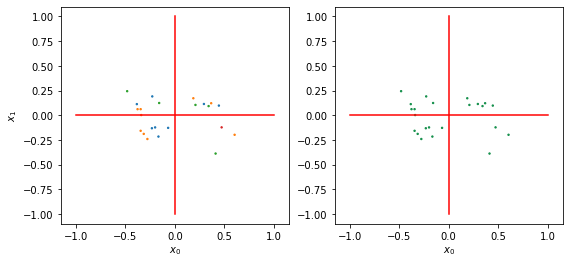

In [5]:
ql.set_parameters(parameters)
value_loss = ql.cost_function_fidelity()
print('The value of the cost function achieved is %.6f' % value_loss.numpy())
ql.paint_results()